In [1]:
import sys
import matplotlib.pyplot as plt
import matplotlib as mpl
import statsmodels.api as sm
import seaborn as sns
import numpy as np
import math
from sklearn.cluster import KMeans
from collections import Counter
import pandas as pd
import warnings
import json
import os
import scipy
import gensim

import plotly.express as px
import chart_studio.plotly as py

# Allow python to import modules from the preprocessing folder
sys.path.append("src/preprocessing/")
warnings.filterwarnings("ignore") # For seaborn

from load_dataset import *

SAVE_PATH = "./data/refined"
if not os.path.exists(SAVE_PATH):
    os.mkdir(SAVE_PATH)

# Table of contents
Given the multiple sources of data and the various steps required to set up our future analysis, this notebook is relatively large. To make assessment of our work easier, we provide a table of contents with dynamic links using html anchors for your convenience. Sadly, the dynamic links **do not work** on Github's web interface, so we encourage you to download this notebook and open it in the browser of your choice.

## [Part 0: Requirements](#part_0_title)

### &emsp; [Download data](#part_0_download_data)

## [Part I: Load, explore and join movie datasets](#part_1_title)

### &emsp; [CMU dataset](#part_1_cmu)

#### &emsp; &emsp; [CMU characters](#part_1_cmu_characters)
#### &emsp; &emsp; [CMU movies](#part_1_cmu_movies)
#### &emsp; &emsp; [CMU plots](#part_1_cmu_plots)
#### &emsp; &emsp; [CMU tropes](#part_1_cmu_tropes)

### &emsp; [IMDb dataset](#part_1_imdb)

#### &emsp; &emsp; [IMDb ratings](#part_1_imdb_ratings)
#### &emsp; &emsp; [IMDb titles](#part_1_imdb_title)
#### &emsp; &emsp; [IMDb principals](#part_1_imdb_principals)
#### &emsp; &emsp; [IMDb people](#part_1_imdb_people)

### &emsp; [Joining titles with ratings](#part_1_imdb_title_with_ratings)

### &emsp; [Joining CMU movies & plots with IMDb titles & ratings](#part_1_cmu_movies_joined_imdb_title_with_ratings)

### &emsp; [Joining IMDb people with IMDb principals](#part_1_imdb_people_with_principals)

### &emsp; [Filtering CMU characters](#part_1_cmu_filter_characters)

### &emsp; [Joining CMU characters with IMDb people & principals](#part_1_imdb_actors_characters_with_cmu_characters)

### &emsp; [Part I summary](#part_1_summary)

#### &emsp; &emsp; [Saving](#part_1_saving)

## [Part 2: Character tropes / Personas](#part_2_title)

### &emsp; [TVTropes personas](#part_2_tv_tropes_personas)

#### &emsp; &emsp; [Analyse tropes characters](#part_2_tv_tropes_per_actor)
#### &emsp; &emsp; [Introduction of the preference metric](#part_2_preference_metric)
#### &emsp; &emsp; [Joining TVTropes with movies](#part_2_tvtropes_joined_movies)

### &emsp; [Joining original paper tropes with actors & characters](#part_2_cmu_personas_joined_character)

### &emsp; [Part II summary](#part_2_summary)

#### &emsp; &emsp; [Saving](#part_2_saving)

## [Part 3: Movie based comfort zones](#part_3_movie_based_comfort_zones)

### &emsp; [Based on genre](#part_3_movie_based_comfort_zones_genre)

#### &emsp; &emsp; [Genre frequency vector per actor](#part_3_genre_freq_vector)
#### &emsp; &emsp; [Joining genre frequency vector with actors & characters & tropes](#part_3_merge_characters_genre_freq_vector)
#### &emsp; &emsp; [Saving](#part_3_saving)

### &emsp; [Part III summary](#part_3_summary)

## [Intermezzo : Possible sources of bias and limitations](#part_3_possible_bias_and_limitations)

## [Part 4: Analysis](#part_4_title)

<hr style="height:2px;border:none;color:#333;background-color:#333;">

# Part 0: Requirements <a name="part_0_title"></a>

## Download data <a name="part_0_download_data"></a>

In order to download all required datasets, run the cell bellow (may take a while the first time).

In [2]:
%run src/preprocessing/download_dataset.py

[+] Found cached dataset for url https://www.cs.cmu.edu/~ark/personas/data/MovieSummaries.tar.gz
[+] Found cached dataset for url https://datasets.imdbws.com/title.basics.tsv.gz
[+] Found cached dataset for url https://datasets.imdbws.com/name.basics.tsv.gz
[+] Found cached dataset for url https://datasets.imdbws.com/title.ratings.tsv.gz
[+] Found cached dataset for url https://datasets.imdbws.com/title.principals.tsv.gz
[+] Found cached dataset for url https://raw.githubusercontent.com/MichelDucartier/ACL_personas_dump/master/personas/25.100.lda.cond.log.txt.gz
[+] Found cached dataset for url https://raw.githubusercontent.com/MichelDucartier/ACL_personas_dump/master/personas/25.100.lda.log.txt.gz
[+] Found cached dataset for url https://raw.githubusercontent.com/MichelDucartier/ACL_personas_dump/master/personas/featureFile.txt.gz
[+] Found cached dataset for url https://raw.githubusercontent.com/MichelDucartier/ACL_personas_dump/master/personas/featureMeans.txt.gz
[+] Found cached da

# Part I: Load, explore and join movie datasets <a name="part_1_title"></a>

## CMU dataset <a name="part_1_cmu"></a>

We load the 4 `.tsv` and `.txt` files of the CMU dataset into 4 different dataframes

In [3]:
characters_df = load_characters_df()
movies_df = load_movies_df()
plot_df = load_plot_df()
tvtropes_df = load_tvtropes_df()

### Characters <a name="part_1_cmu_characters"></a>

The characters dataframe comes from the CMU movies dataset. This dataframe describes movie characters and provides information about the actor who played the corresponding character. Here is a sample of this dataframe :

In [4]:
characters_df.sample(5)

,wiki_movie_id,freebase_movie_id,release_date,character_name,actor_birth,actor_gender,actor_height,actor_ethnicity,actor_name,release_actor_age,freebase_map_id,freebase_character_id,freebase_actor_id
175204,20986251,/m/05b3629,2008-08-16,Evangelist,NaN,M,NaN,NaN,Mike Critelli,NaN,/m/0k20lj9,/m/0k20ljd,/m/0h37pxl
433724,21012631,/m/064rcvj,2009-11-24,Sniffer,1933-12-15,M,1.68,NaN,Tim Conway,75.0,/m/09j2j6r,/m/0h5cvt0,/m/01nrgq
133426,31258406,/m/0gjdrgq,1999,Hajiyar,1953-10-06,M,NaN,/m/04mvp8,Raghu,45.0,/m/0h7sh2s,/m/0h8jl17,/m/047f71z
91593,4055526,/m/0bfv4r,1990,NaN,1928-02-07,M,NaN,NaN,Leonard Jackson,61.0,/m/0cg0c33,NaN,/m/0bpjhlk
436149,14746213,/m/03gwdh3,1991,NaN,1964-08-10,M,NaN,NaN,Steven Vincent Leigh,26.0,/m/0gcjm9f,NaN,/m/02z5jrq


In [5]:
total_characters = len(characters_df)
print(f"Number of characters loaded: {total_characters}")
print(f"Number of unique movies: {len(characters_df['wiki_movie_id'].unique())}")
print(f"Number of unique actors: {len(characters_df['freebase_actor_id'].unique())}", end="\n\n")

print(f"Percentage of missing gender: {characters_df['actor_gender'].isna().sum()/total_characters*100:.2f}%")
print(f"Percentage of missing height: {characters_df['actor_height'].isna().sum()/total_characters*100:.2f}%")
print(f"Percentage of missing ethnicity: {characters_df['actor_ethnicity'].isna().sum()/total_characters*100:.2f}%")
print(f"Percentage of missing age upon release: {characters_df['release_actor_age'].isna().sum()/total_characters*100:.2f}%", end="\n\n")

print(f"Number of character records for which ethnicity is known: {len(characters_df[~characters_df['actor_ethnicity'].isna()])}")
print(f"Number of unique actors for which ethnicity is known: {len(characters_df[~characters_df['actor_ethnicity'].isna()]['freebase_actor_id'].unique())}")

Number of characters loaded: 450669
Number of unique movies: 64330
Number of unique actors: 135761

Percentage of missing gender: 10.12%
Percentage of missing height: 65.65%
Percentage of missing ethnicity: 76.47%
Percentage of missing age upon release: 35.08%

Number of character records for which ethnicity is known: 106058
Number of unique actors for which ethnicity is known: 8151


We can first notice that a great percentage of actor's ethnicity is missing. This may become a problem when we study the impact of actors' ethnicity on the success of a movie. Let's investigate a bit.

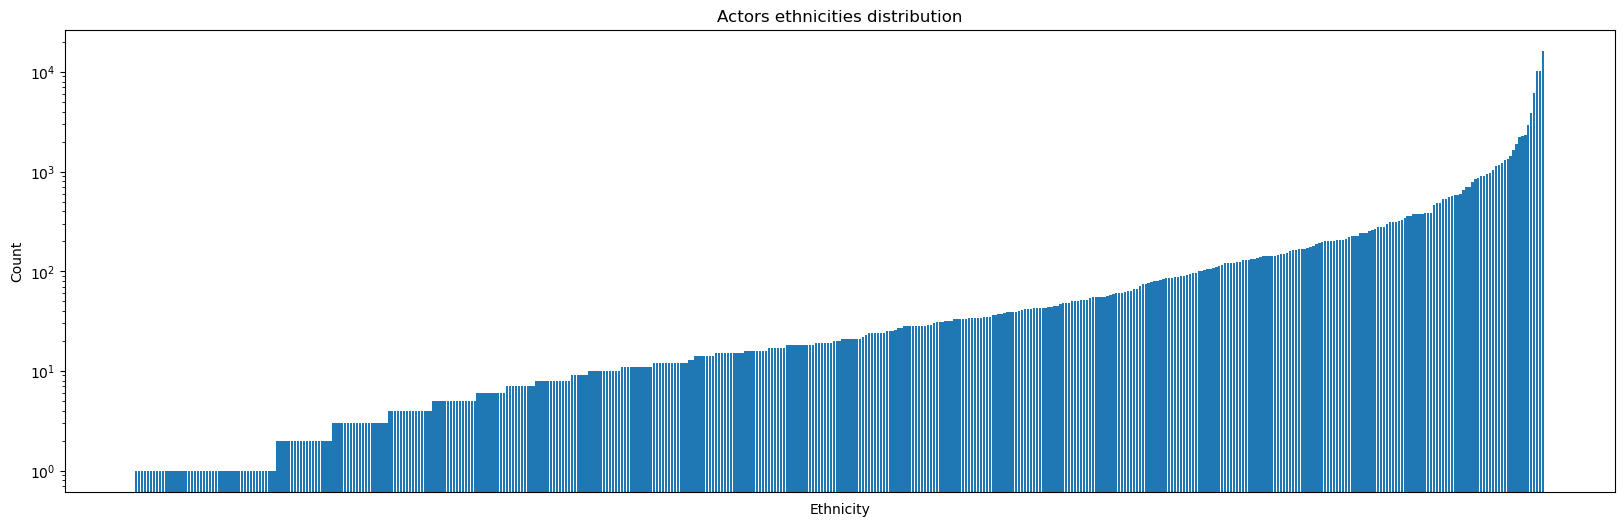

In [6]:
actors_ethnicities = characters_df[['freebase_actor_id', 'actor_ethnicity']].dropna().groupby(by='actor_ethnicity').count()
actors_ethnicities = actors_ethnicities.sort_values(by='freebase_actor_id')

plt.figure(figsize=(20,6))
plt.bar(actors_ethnicities.index, actors_ethnicities['freebase_actor_id'], label='')
plt.title("Actors ethnicities distribution")
plt.yscale('log')
plt.xticks([])
plt.ylabel("Count")
plt.xlabel("Ethnicity")
plt.show()

As shown, the ethnicities distribution is very heterogeneous. Some ethnicities have only one representative whereas others have more than thousands elements. During analysis, we must be careful on our conclusions as variance gets higher for the ethnicities with fewer representatives. Fortunately, we can quantify uncertainty in our results using tools like p-value and confidence interval.

### Movies <a name="part_1_cmu_movies"></a>

The movies dataframe also comes from the CMU dataset and provides information about movies such as its origins, runtime and box office.

In [7]:
movies_df.sample(5)

,wiki_movie_id,freebase_movie_id,movie_name,movie_release_date,box_office,movie_runtime,movie_languages,movie_countries,movie_genres
39703,13576050,/m/03c9w26,Duality,2006-06-02,NaN,100.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"{'/m/0lsxr': 'Crime Fiction', '/m/01z4y': 'Com..."
11738,2546555,/m/07m7s0,The Tramp,1915-04-11,NaN,32.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"{'/m/06cvj': 'Romantic comedy', '/m/06ppq': 'S..."
11280,8916783,/m/027pkcp,Murder in the Hamptons,2005-07-11,NaN,88.0,{'/m/02h40lc': 'English Language'},{'/m/0d060g': 'Canada'},"{'/m/0lsxr': 'Crime Fiction', '/m/07s9rl0': 'D..."
678,28400904,/m/0crh665,Typeface,2009,NaN,59.0,{},{'/m/09c7w0': 'United States of America'},{'/m/0jtdp': 'Documentary'}
33392,35838902,/m/0b447ks,Another Dawn,1937-06-18,NaN,73.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"{'/m/02l7c8': 'Romance Film', '/m/07s9rl0': 'D..."


In [8]:
total_movies = len(movies_df)
print(f"Number of movies loaded: {total_movies}")
print(f"Percentage of missing box office revenue: {movies_df['box_office'].isna().sum()/total_movies*100:.2f}%")
print(f"Number of movies for which we have matching character data: {len(movies_df.merge(characters_df, how='inner', on=['wiki_movie_id', 'freebase_movie_id'])['freebase_movie_id'].unique())}")

Number of movies loaded: 81741
Percentage of missing box office revenue: 89.72%
Number of movies for which we have matching character data: 64330


A great proportion of box office revenue data is missing (almost 90%). This makes sense as lots of movies are not shown in cinemas such as TV movies, short movies. Indeed, to get a movie to the box office, one needs to work with studios or convince distributors to distribute the movie.

Thus, using box office as a way to measure a movie's performance may be biased because we already filter a specific type of movie. Furthermore, box office does not necessarily reflect the quality of a movie. Indeed some movies may not get a high box office revenue because of a lack of advertising. To fix this issue, we will use users rating from the IMDb database.

In [9]:
# Extract years from the release date of movies
movies_df['movie_release_year'] = movies_df[~movies_df['movie_release_date'].isna()]['movie_release_date'].astype(str).str[:4].astype(int)

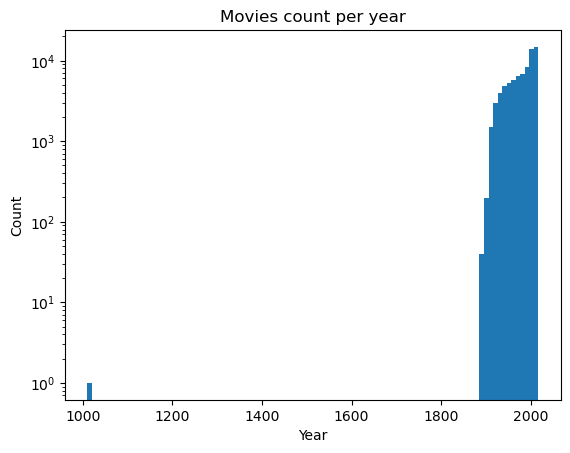

In [10]:
plt.hist(movies_df['movie_release_year'], bins=100)
plt.yscale("log")
plt.xlabel("Year")
plt.ylabel("Count")
plt.title("Movies count per year")
plt.show()

We notice that a movie has been produced 700 years before the invention of potography ! Let's investigate:

In [11]:
wrong_dates = movies_df[movies_df['movie_release_year'] < 1800].index
movies_df.loc[wrong_dates]

,wiki_movie_id,freebase_movie_id,movie_name,movie_release_date,box_office,movie_runtime,movie_languages,movie_countries,movie_genres,movie_release_year
62836,29666067,/m/0fphzrf,Hunting Season,1010-12-02,12160978.0,140.0,"{'/m/02hwyss': 'Turkish Language', '/m/02h40lc...",{'/m/01znc_': 'Turkey'},"{'/m/0lsxr': 'Crime Fiction', '/m/02n4kr': 'My...",1010.0


By googling the movie's name, we find that `Hunting season` should be released in 2010 (instead of 1010). This is obviously a typo and 1010 should be replaced by 2010.

In [12]:
# A movie that has the release date 1010. We fix the typo to 2010
movies_df.loc[wrong_dates, 'movie_release_year']= 2010
movies_df.loc[wrong_dates, 'movie_release_date'] ='2010-12-02'

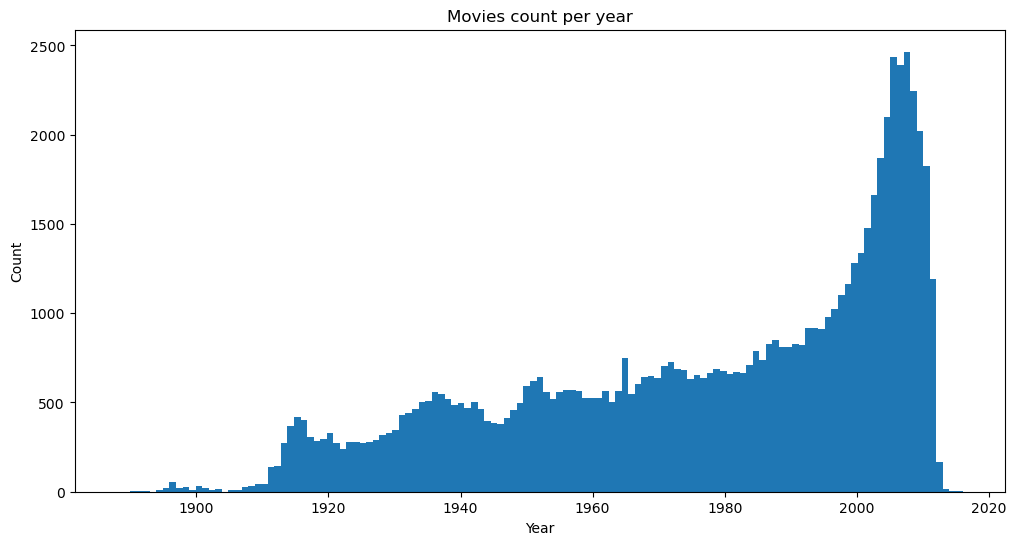

In [13]:
n_years = len(movies_df['movie_release_year'].dropna().unique())

plt.figure(figsize=(12, 6))
plt.hist(movies_df['movie_release_year'], bins=n_years)
plt.xlabel("Year")
plt.ylabel("Count")
plt.title("Movies count per year")
plt.show()

There are significantly more movies released after 1990 than before in our dataset.

### Plots <a name="part_1_cmu_plots"></a>

The plot dataframe comes from the CMU dataset and provides a summary of the plot of a given movie.

In [14]:
plot_df.sample(5)

,wiki_movie_id,plot_summary
2706,8595532,In April 1942 the crew of a downed American B-...
20166,13760378,Louis Coline is an executive assistant in a d...
25733,12561211,Pilot Jack Savage is suspected of drinking an...
26317,23666206,Sukumari plays a key role of an aged lady name...
18617,21152826,It tells the story of a promoter who helps a H...


In [15]:
total_plot = len(plot_df)
print(f"Number of plot summaries loaded: {total_plot}")

Number of plot summaries loaded: 42303


### Tropes <a name="part_1_cmu_tropes"></a>

The tvtropes dataframe is the one used by the CMU researchers to validate their personas learning algorithm. Unfortunately, this dataset does not contain a lot of tvtropes and can not be used for our analysis. Thus we need other databases to get the persona of movie characters.

In [16]:
tvtropes_df.sample(5)

,trope_name,character_data
14,arrogant_kungfu_guy,"{'char': 'Clubber Lang', 'movie': 'Rocky III',..."
240,fastest_gun_in_the_west,"{'char': 'Ben Wade', 'movie': '3:10 to Yuma', ..."
181,dirty_cop,"{'char': 'Abel Turner', 'movie': 'Lakeview Ter..."
46,brainless_beauty,"{'char': 'Maggie Feller', 'movie': 'In Her Sho..."
375,playful_hacker,"{'char': 'Mr. Universe', 'movie': 'Serenity', ..."


In [17]:
total_tropes = len(tvtropes_df)
print(f"Number of tropes loaded: {total_tropes}")

Number of tropes loaded: 501


## IMDB dataset <a name="part_1_imdb"></a>

We need to define a metric of "success" of a film. Even if we are already provided with the `box_office` column in the cmu dataset, it only includes data for the bigger movies, wihch represent only 10% of the movies. We have therefore decided to use the imdb rating of the film as a metric defining its performance.

We also used the `people` and `principals` collections from IMDb to enrich the `characters` collection from the CMU corpus, reducing the amount of missing information.

We load the 4 `.tsv` files of the IMDB dataset into 4 different dataframes

In [18]:
imdb_ratings_df = load_imdb_ratings()
imdb_title_df = load_imdb_title_basics()
imdb_principals_df = load_imdb_title_principals()
imdb_people_df = load_imdb_person_basics()

In [19]:
imdb_principals_df.sample(5)

,tconst,ordering,nconst,category,job,characters
47890530,tt5607396,5,nm6542886,director,\N,\N
27894224,tt1802593,4,nm0111910,actress,\N,"[""Janine Malloy""]"
41496244,tt29899346,6,nm0014215,actor,\N,"[""Shin Deok Su""]"
51620809,tt7133650,8,nm5356588,producer,producer,\N
40513385,tt29099638,3,nm15292922,self,\N,"[""Self - Announcer"",""Co-Host""]"


### Ratings <a name="part_1_imdb_ratings"></a>

In [20]:
imdb_ratings_df.sample(5)

,tconst,averageRating,numVotes
116873,tt0171519,6.6,17
1173122,tt5543754,6.9,41
860764,tt2084865,6.2,106
902825,tt2248045,5.4,8
1203576,tt6026640,5.6,48


We have 1377585 movies for which we have a rating.


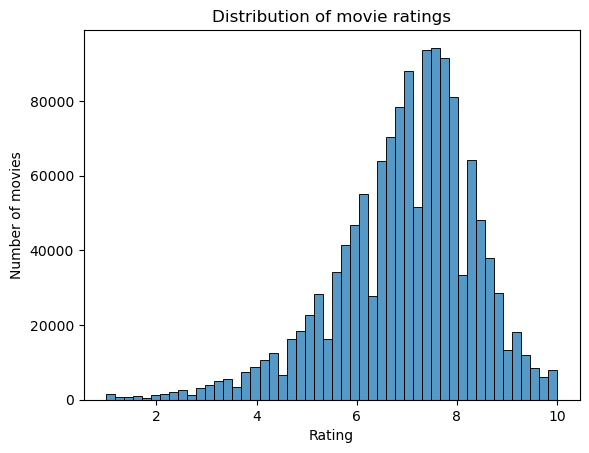

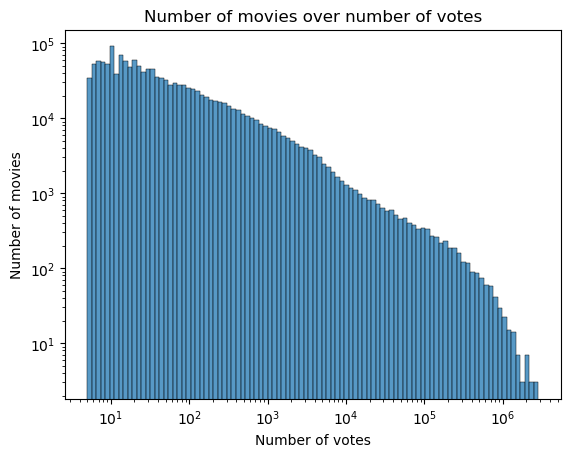

In [21]:
total_ratings = len(imdb_ratings_df)
print(f"We have {total_ratings} movies for which we have a rating.")

# Check the distribution of grades
sns.histplot(data=imdb_ratings_df, x="averageRating", bins=50)

plt.title("Distribution of movie ratings")
plt.xlabel("Rating")
plt.ylabel("Number of movies")
plt.show()

# Check the distribution of votes
sns.histplot(data=imdb_ratings_df, x="numVotes", bins=100, log_scale=True)
plt.yscale("log")

plt.title("Number of movies over number of votes")
plt.xlabel("Number of votes")
plt.ylabel("Number of movies")
plt.show()

### Titles <a name="part_1_imdb_title"></a>

In [22]:
imdb_title_df.sample(5)

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
4590105,tt17164334,movie,The Snow Queen and the Princess,Snezhnaya koroleva: Razmorozka,0,2022,\N,75,"[Adventure, Animation, Fantasy]"
3830918,tt15249704,movie,Undateable,Undateable,0,2018,\N,\N,[Romance]
9673595,tt8370242,movie,The Bubble-Wand Remixes,The Bubble-Wand Remixes,0,2009,\N,77,[Comedy]
835744,tt0863111,movie,Bastardi,Bastardi,0,2008,\N,88,[Thriller]
301122,tt0314652,movie,Shachô enmachô,Shachô enmachô,0,1969,\N,90,\N


In [23]:
# Remove adult content
imdb_title_df = imdb_title_df[imdb_title_df["isAdult"].astype(int) == 0]
total_title = len(imdb_title_df)
print(f"We have {total_title} movie titles")

We have 655244 movie titles


### Principals <a name="part_1_imdb_principals"></a>

In [24]:
total_principals = len(imdb_principals_df)
print(f"We have {total_principals} principals records")
print(f"We have {len(imdb_principals_df['category'].unique())} categories")
print(f"We have {len(imdb_principals_df['nconst'].unique())} unique persons", end="\n\n")

imdb_principals_df.sample(5)

We have 59463445 principals records
We have 12 categories
We have 5204414 unique persons



,tconst,ordering,nconst,category,job,characters
14006153,tt11926854,9,nm0914844,writer,creator,\N
32126838,tt21416202,2,nm1716790,actor,\N,"[""Giani""]"
2190083,tt0295729,9,nm1046482,writer,novel,\N
30699376,tt20501278,10,nm7053950,producer,producer,\N
21691224,tt1465136,2,nm1383586,actor,\N,"[""Jared Banks""]"


### People <a name="part_1_imdb_people"></a>

In [25]:
total_people = len(imdb_people_df)
print(f"We have {total_people} people records")
print(f"We have {len(imdb_people_df['nconst'].unique())} unique persons")

imdb_people_df.sample(5)

We have 13070396 people records
We have 13070396 unique persons


,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles
12090545,nm8800984,Jimmy Malcolm,\N,\N,NaN,[\N]
5137225,nm14532841,Gokhan Celik,\N,\N,[camera_department],[tt26627860]
6541333,nm2102846,Pawel Szastak,\N,\N,[camera_department],"[tt5732634, tt5318042, tt10666454, tt10340366]"
3997145,nm13249676,TiaaMariee,\N,\N,NaN,[\N]
7760828,nm3476978,José Ramón Barreto,\N,\N,"[actor, producer]","[tt14707676, tt9327242, tt2856378, tt17319764]"


## Merge IMDb movie titles with IMDb ratings <a name="part_1_imdb_title_with_ratings"></a>

In [26]:
imdb_title_with_rating = imdb_title_df.merge(imdb_ratings_df, on='tconst', how='inner')

total_movies_w_rating = len(imdb_title_with_rating)
print(f"We have {total_movies_w_rating} movies with ratings")

imdb_title_with_rating.sample(5)

We have 296385 movies with ratings


,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes
55550,tt0101571,movie,Fun and Fury,Chi qing kuai xu,0,1992,\N,101,"[Action, Comedy]",5.9,51
186662,tt15670384,movie,Mundo Novo,Mundo Novo,0,2021,\N,84,[Drama],7.6,7
115222,tt0345535,movie,Kung aagawin mo ang lahat sa akin,Kung aagawin mo ang lahat sa akin,0,1987,\N,\N,[Drama],7.3,11
210068,tt21302306,movie,Danny Goes Aum,Danny Goes Aum,0,2023,\N,\N,\N,8.9,8
148551,tt1065107,movie,Profile,Profile,0,2008,\N,\N,"[Crime, Drama]",8.1,8


There is more than one quarter of a million movies for which we have at least one rating. We have clearly much more data to work with than with box office revenue. Furthermore, there is a substantial amount of movies who have at least a few hundreds votes. This will allow us to get better confidence interval and reduce uncertainty in our analysis.

## Merge CMU movies and plot summaries with IMDB titles and ratings <a name="part_1_cmu_movies_joined_imdb_title_with_ratings"></a>

The translation dataframe from wikidata, which includes both the IMDB id and the Freebase id, enables us to combine the IMDB dataset with the CMU dataset

In [27]:
translation_id = load_translation_df()

imdb_title_with_rating_translated = imdb_title_with_rating.merge(translation_id, how='inner', left_on='tconst', right_on='imdb_id').copy()
imdb_title_with_rating_translated = imdb_title_with_rating_translated.drop(["imdb_id"], axis=1)

cmu_movies_w_imdb_rating = imdb_title_with_rating_translated.merge(movies_df, how='inner', left_on='freebase_id', right_on='freebase_movie_id').copy()

# Enriching CMU data
# IMDB start year has no missing data, so we insert it into "NaN" fields of "movie_release_date" and drop "startYear"
missing_years = cmu_movies_w_imdb_rating[cmu_movies_w_imdb_rating['movie_release_date'].isna()].index
cmu_movies_w_imdb_rating.loc[missing_years, 'movie_release_date'] = cmu_movies_w_imdb_rating.loc[missing_years, 'startYear']

# We have MANY depulicated attributes
# We evaluated for each pair which column had more missing data and dropped it in favor of the other
cmu_movies_w_imdb_rating = cmu_movies_w_imdb_rating.drop(["freebase_movie_id", "titleType", "isAdult", "endYear", "primaryTitle", "originalTitle", "movie_release_year", "movie_runtime", "startYear"], axis=1)

cmu_movies_w_imdb_rating = cmu_movies_w_imdb_rating.drop_duplicates("tconst")
print(f"The merged dataframe contains {len(cmu_movies_w_imdb_rating)} movies with corresponding ratings")

The merged dataframe contains 44509 movies with corresponding ratings


In [28]:
# Add summaries
cmu_movies_w_imdb_rating = cmu_movies_w_imdb_rating.merge(plot_df, on="wiki_movie_id", how="left")
cmu_movies_w_imdb_rating.sample(5)

,tconst,runtimeMinutes,genres,averageRating,numVotes,freebase_id,wiki_movie_id,movie_name,movie_release_date,box_office,movie_languages,movie_countries,movie_genres,plot_summary
8958,tt0045712,78,[Comedy],4.8,350,/m/04ghsbz,18677374,Two Nights with Cleopatra,1953,NaN,{'/m/02bjrlw': 'Italian Language'},{'/m/03rjj': 'Italy'},"{'/m/06cvj': 'Romantic comedy', '/m/02l7c8': '...",NaN
5100,tt0033432,92,"[Comedy, Romance]",6.9,3651,/m/027qt0p,8947775,The Bride Came C.O.D.,1941,NaN,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"{'/m/06cvj': 'Romantic comedy', '/m/06qm3': 'S...",Pilot Steve Collins agrees to help bandleader...
32744,tt0312549,98,"[Biography, Crime, Drama]",6.8,21610,/m/04__tq,1419414,Veronica Guerin,2003-07-08,9439660.0,{'/m/02h40lc': 'English Language'},"{'/m/09c7w0': 'United States of America', '/m/...","{'/m/0lsxr': 'Crime Fiction', '/m/017fp': 'Bio...",Veronica Guerin is a feisty crime reporter fo...
14222,tt0062665,90,[Mystery],5.4,26,/m/0bwksnz,27159792,Amsterdam Affair,1970,NaN,{'/m/02h40lc': 'English Language'},{'/m/07ssc': 'United Kingdom'},{'/m/02n4kr': 'Mystery'},NaN
21457,tt0093898,99,[Drama],5.5,1608,/m/02r209n,11158587,Russkies,1987-11-06,NaN,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"{'/m/0hqxf': 'Family Film', '/m/02h8pkk': 'Fam...","A few nights before July 4, three government/m..."


## Merge IMDb people and IMDb principals <a name="part_1_imdb_people_with_principals"></a>
We now focus on characters and actors. We merge the two dataframes from IMDB and keep records of interest i.e for which the movie is in the collection above.

In [29]:
titles_of_interest = set(cmu_movies_w_imdb_rating["tconst"].to_list())

imdb_people_not_nan = imdb_people_df[imdb_people_df["primaryProfession"].notna()]

# Filter IMDb data to keep actors and actresses
imdb_actors = imdb_people_not_nan[imdb_people_not_nan["primaryProfession"].apply(lambda l : ("actor" in l) or ("actress" in l))].copy()
imdb_principals_actors = imdb_principals_df[(imdb_principals_df["category"] == "actress") | (imdb_principals_df["category"] == "actor")].copy()

imdb_actors_and_characters = imdb_actors.merge(imdb_principals_actors, on="nconst", how="inner").copy()

# Only keep actors and actresses from movies that have a rating
imdb_actors_and_characters = imdb_actors_and_characters[imdb_actors_and_characters["tconst"].isin(titles_of_interest)]
imdb_actors_and_characters = imdb_actors_and_characters.drop(["ordering", "category", "job", "primaryProfession"], axis=1)

In [30]:
imdb_actors_and_characters.sample(5)

,nconst,primaryName,birthYear,deathYear,knownForTitles,tconst,characters
4131802,nm0334318,Stephen Graham,1973,\N,"[tt1790809, tt0208092, tt0480025, tt11127680]",tt0396096,"[""Harry""]"
2883970,nm0210274,Alberto de Mendoza,1923,2011,"[tt1725021, tt0434382, tt0179248, tt0068713]",tt0063492,"[""Zakir, Police Captain""]"
1447711,nm0084444,Smriti Biswas,\N,\N,"[tt0047796, tt0231209, tt0156443, tt0247291]",tt0053104,\N
9162558,nm0955782,Xun Zhou,1974,\N,"[tt0454914, tt1371111, tt1299370, tt0465676]",tt0454914,"[""Sun Na"",""Xiaoyu""]"
9034008,nm0934798,Marie Windsor,1919,2000,"[tt0049406, tt0045609, tt0055893, tt0048682]",tt0047074,"[""Rose Otis""]"


## Filter CMU characters <a name="part_1_cmu_filter_characters"></a>
We keep records of interest in the same fashion as done above

In [31]:
titles_of_interest_wiki = cmu_movies_w_imdb_rating["wiki_movie_id"].to_list()
characters_interest = characters_df[characters_df["wiki_movie_id"].isin(titles_of_interest_wiki)]
characters_interest.sample(5)

,wiki_movie_id,freebase_movie_id,release_date,character_name,actor_birth,actor_gender,actor_height,actor_ethnicity,actor_name,release_actor_age,freebase_map_id,freebase_character_id,freebase_actor_id
402180,18814709,/m/04glz_r,2009,NaN,NaN,NaN,NaN,NaN,Jaimi Paige,NaN,/m/0gc81tj,NaN,/m/0gc3jm2
88144,2982688,/m/08hmch,2009-04-28,Wolverine,1968-10-12,M,1.89,/m/0bbz66j,Hugh Jackman,40.0,/m/03dzls4,/m/01s283,/m/03h_9lg
30016,915487,/m/03pkjn,1992-08-21,NaN,1965-08-10,NaN,1.87,NaN,Eric Thal,27.0,/m/0cs0wdx,NaN,/m/09q2bw9
336131,3645005,/m/09rx_8,1978-06-19,Inspector Clouseau,1925-09-08,M,1.73,/m/041rx,Peter Sellers,52.0,/m/0k2j12,/m/0ckgm,/m/063_t
40233,2680994,/m/07xkmm,1987-04-10,Loser,NaN,M,NaN,NaN,Lenny Rose,NaN,/m/0j7226n,/m/0j7226r,/m/0gc0h9h


## Merge IMDb actors and characters with CMU characters <a name="part_1_imdb_actors_characters_with_cmu_characters"></a>

We merge IMDB character and actor data with the CMU data. We make use of the movie translation dataframe again and the actor translation dataframe. We assume that an actor only plays one role in a movie. This is not necessarily true as some actors may play many roles in the same movie, but we assume that those cases are sufficiently rare so that we can ignore them.

In [32]:
# Actor translation dataframe
actor_translation_df = load_actors_translation_df()
actor_translation_df = actor_translation_df.rename(columns={'imdb_id' : 'actor_imdb_id', 'freebase_id' : 'actor_freebase_id'})

In [33]:
# Prepare the datasets for merging by adding translation information
imdb_actors_and_characters_translated = imdb_actors_and_characters.merge(translation_id, how='inner', left_on='tconst', right_on='imdb_id').copy()
imdb_actors_and_characters_translated = imdb_actors_and_characters_translated.merge(actor_translation_df, how='inner', left_on='nconst', right_on='actor_imdb_id')
imdb_actors_and_characters_translated = imdb_actors_and_characters_translated.drop(["imdb_id", "actor_imdb_id"], axis=1)

In [34]:
imdb_actors_w_cmu_characters = imdb_actors_and_characters_translated.merge(characters_interest, how='right', left_on=['freebase_id', 'actor_freebase_id'], right_on=['freebase_movie_id', 'freebase_actor_id']).copy()

In [35]:
# Merge birth year information
missing_birth_years = imdb_actors_w_cmu_characters[imdb_actors_w_cmu_characters['actor_birth'].isna()].index
imdb_actors_w_cmu_characters.loc[missing_birth_years, 'actor_birth'] = imdb_actors_w_cmu_characters.loc[missing_birth_years, 'birthYear']

def get_first_characters(ls):
    """
    Retrieves the first character of the corresponding IMDb column

    Parameters
    ----------
    ls : str
        List-like string of characters
        
    Returns
    -------
    str
        The character name
    """
    
    if isinstance(ls, float) | (ls == "\\N"):
        return np.nan
    return ls.split('"')[1]

# Merge character information
imdb_actors_w_cmu_characters["characters"] = imdb_actors_w_cmu_characters["characters"].apply(get_first_characters)
missing_characters = imdb_actors_w_cmu_characters[imdb_actors_w_cmu_characters['character_name'].isna()].index
imdb_actors_w_cmu_characters.loc[missing_characters, 'character_name'] = imdb_actors_w_cmu_characters.loc[missing_characters, 'characters']

# Drop duplicates and column names
imdb_actors_w_cmu_characters = imdb_actors_w_cmu_characters.drop(["freebase_id", "actor_freebase_id", "primaryName", "deathYear", "birthYear", "knownForTitles", "nconst", "tconst", "characters"], axis=1)
imdb_actors_w_cmu_characters = imdb_actors_w_cmu_characters.drop_duplicates(subset="freebase_map_id")
imdb_actors_w_cmu_characters = imdb_actors_w_cmu_characters.rename(columns={'freebase_movie_id' : 'freebase_id'})

imdb_actors_w_cmu_characters.head(5)

,wiki_movie_id,freebase_id,release_date,character_name,actor_birth,actor_gender,actor_height,actor_ethnicity,actor_name,release_actor_age,freebase_map_id,freebase_character_id,freebase_actor_id
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg


## Summary of results for part I <a name="part_1_summary"></a>
We now have two main dataframes for further analysis. One containing everything related to movies and their ratings and the other containing everything related to actors, their features and characters they played in a given movie.

In [36]:
movies = cmu_movies_w_imdb_rating.copy()
actors_characters = imdb_actors_w_cmu_characters.copy()
movies.head()

,tconst,runtimeMinutes,genres,averageRating,numVotes,freebase_id,wiki_movie_id,movie_name,movie_release_date,box_office,movie_languages,movie_countries,movie_genres,plot_summary
0,tt0000009,45,[Romance],5.3,207,/m/02q23xk,10109752,Miss Jerry,1894-10-09,NaN,{'/m/06ppq': 'Silent film'},{'/m/09c7w0': 'United States of America'},"{'/m/02hmvc': 'Short Film', '/m/06ppq': 'Silen...",After finding out that her father is suffering...
1,tt0000147,100,"[Documentary, News, Sport]",5.3,485,/m/0czdh_n,28703057,The Corbett-Fitzsimmons Fight,1897-05-22,100000.0,{},{},{'/m/01z02hx': 'Sports'},The film no longer exists in its entirety; how...
2,tt0000574,70,"[Action, Adventure, Biography]",6.0,856,/m/0120y4,142995,The Story of the Kelly Gang,1906-12-26,NaN,{'/m/02h40lc': 'English Language'},{'/m/0chghy': 'Australia'},"{'/m/0lsxr': 'Crime Fiction', '/m/06ppq': 'Sil...",The Story of the Kelly Gangs tone is of sorrow...
3,tt0000591,90,[Drama],5.0,21,/m/07s67rr,4849466,L'Enfant prodigue,1907-06-20,NaN,{'/m/064_8sq': 'French Language'},{'/m/0f8l9c': 'France'},"{'/m/02hmvc': 'Short Film', '/m/06ppq': 'Silen...",NaN
4,tt0000679,120,"[Adventure, Fantasy]",5.0,70,/m/0fgfyy,5954041,The Fairylogue and Radio-Plays,1908-09-24,NaN,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"{'/m/06ppq': 'Silent film', '/m/01g6gs': 'Blac...",NaN


In [37]:
actors_characters.head()

,wiki_movie_id,freebase_id,release_date,character_name,actor_birth,actor_gender,actor_height,actor_ethnicity,actor_name,release_actor_age,freebase_map_id,freebase_character_id,freebase_actor_id
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg


### Saving <a name="part_1_saving"></a>

In [38]:
movies.to_json(os.path.join(SAVE_PATH, "movies.json"), orient='records')

In [39]:
actors_characters.to_json(os.path.join(SAVE_PATH, "characters.json"), orient='records')

# Part II: Character tropes / Personas <a name="part_2_title"></a>

In [40]:
# Load results of part I
movies = pd.read_json(os.path.join(SAVE_PATH, "movies.json"))
actors_characters = pd.read_json(os.path.join(SAVE_PATH, "characters.json"))

## TVTropes personas <a name="part_2_tv_tropes_personas"></a>
We now load the 500 personas records we extracted from TVTropes

In [41]:
tvtropes_personas = load_tv_tropes_personas_df()
tvtropes_personas.head()

,id,trope,actor,character,movie_name
0,/m/02wszk9,chanteuse,Kathleen Turner,Jessica Rabbit,Who Framed Roger Rabbit
1,/m/0k5wls,chanteuse,Cameron Diaz,Tina Carlyle,The Mask
2,/m/0k50tl,chanteuse,Michelle Pfeiffer,Susie Diamond,The Fabulous Baker Boys
3,/m/0k3j8v,chanteuse,Marilyn Monroe,Sugar Kane Kowalczyk,Some Like It Hot
4,/m/0jvlc4,chanteuse,Isabella Rossellini,Dorothy Vallens,Blue Velvet


### Analyse tropes per actor <a name="part_2_tv_tropes_per_actor"></a>
Let's see if actors have diverse tropes

In [42]:
# We group by actors and aggregate tropes together. We sort the resulting dataframe by the number of tropes
tvtropes_per_actor = tvtropes_personas[["actor", "trope"]].copy().groupby("actor").agg(list).reset_index()
tvtropes_per_actor["num_tropes"] = tvtropes_per_actor["trope"].apply(lambda ls: len(list(dict.fromkeys(ls))))
tvtropes_per_actor = tvtropes_per_actor.sort_values("num_tropes", ascending = False)

tvtropes_per_actor.head()

,actor,trope,num_tropes
166,Johnny Depp,"[casanova, charmer, byronic_hero, byronic_hero...",7
279,Robert De Niro,"[crazy_jealous_guy, crazy_jealous_guy, tranqui...",6
109,Harrison Ford,"[charmer, bounty_hunter, loveable_rogue, trick...",6
57,Clint Eastwood,"[retired_outlaw, heartbroken_badass, bounty_hu...",6
64,Daniel Craig,"[cultured_badass, heartbroken_badass, charmer,...",5


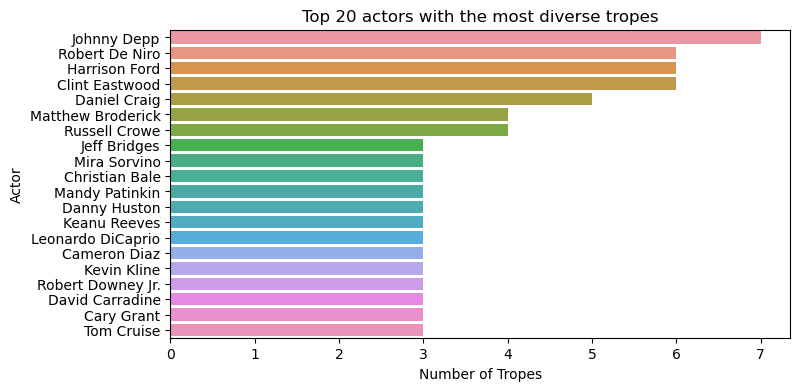

In [43]:
plt.figure(figsize=(8, 4))
sns.barplot(data = tvtropes_per_actor.head(20), x="num_tropes", y="actor", orient='h')
plt.xlabel('Number of Tropes')
plt.ylabel('Actor')
plt.title('Top 20 actors with the most diverse tropes')
plt.show()

As we can see we have a problem. We only have very few well known actors with multiple personas. This makes further analysis impossible, but we use this very high quality dataset to introduce our metrics

### Preference Metric <a name="part_2_preference_metric"></a>

As describe in the [`README.md`](./README.md#methods), we need a **preference metric** per actor. This metric should measure the tendency for a given actor $A$ to have a preferred trope (or set of tropes). A naïve approach would be to compare the distribution of a given actor $A$ to the uniform distribution of tropes. However a rapid analysis show us that the global tropes distribution is not uniform (and as such a more meaningful metric should be determined).



A more meaningfull metric need to be extracted

- **Cross Entropy based metric**:
       
   The Cross Entropy Metric focuses on the entropy of persona choices given the actor
   $$\text{pref}(\text{actor}) = \frac{ H(\text{Persona}) }{ H(\text{Persona} | \text{Actor} = \text{actor})}$$

   This metric has the following property
   - If the actor $a$ always plays the same persona, then $\text{pref}(a) = +\infty$
   - If the actor $a$ plays each persona randomly (same distribution than the global distribution), then $\text{pref}(a) = 1$

   > Note that this metric is not well-behaved as it is not bounded. We can take the inverse to keep a value between 0 and 1, the value 1 would mean that $A$ plays each persona randomly and 0 would mean that $A$ keeps playing the same persona

In [44]:
# Implementation of the cross entropy per actors
tvtropes_per_actor_filtered = tvtropes_per_actor[tvtropes_per_actor["num_tropes"] > 3].copy()
tvtropes_per_actor_filtered

def compute_entropy(array_like):
    array_like = list(array_like)
    dic = {}
    for elem in array_like:
        dic[elem] = dic.get(elem, 0) + 1
    occurences = np.array(list(dic.values()))
    probabilities = occurences / np.sum(occurences)
    return -np.dot(np.log2(probabilities), probabilities)

H_global = compute_entropy(tvtropes_per_actor_filtered['trope'].sum())

tvtropes_per_actor_filtered['cross_entropy_based'] = H_global / tvtropes_per_actor_filtered['trope'].apply(compute_entropy)
tvtropes_per_actor_filtered.head()

,actor,trope,num_tropes,cross_entropy_based
166,Johnny Depp,"[casanova, charmer, byronic_hero, byronic_hero...",7,1.598494
279,Robert De Niro,"[crazy_jealous_guy, crazy_jealous_guy, tranqui...",6,1.756055
109,Harrison Ford,"[charmer, bounty_hunter, loveable_rogue, trick...",6,1.827315
57,Clint Eastwood,"[retired_outlaw, heartbroken_badass, bounty_hu...",6,1.743254
64,Daniel Craig,"[cultured_badass, heartbroken_badass, charmer,...",5,1.893194


- **Mutual Information**:

   The Mutual Information Metric captures the information gain about the actor's persona choices relative to the global persona distribution
   $$\text{pref}(\text{actor}) = \frac{ H(\text{Persona}) - H(\text{Persona} | \text{Actor} = \text{actor}) }{H(\text{Persona})}$$
      
   This metric has the following property
   - If the actor $a$ always plays the same persona, then $\text{pref}(a) = 1$
   - If the actor $a$ plays each persona randomly (same distribution than the global distribution), then $\text{pref}(a) = 0$

In [45]:
tvtropes_per_actor_filtered['mutual_information_based'] = (H_global - tvtropes_per_actor_filtered['trope'].apply(compute_entropy)) / H_global
tvtropes_per_actor_filtered.head()

,actor,trope,num_tropes,cross_entropy_based,mutual_information_based
166,Johnny Depp,"[casanova, charmer, byronic_hero, byronic_hero...",7,1.598494,0.374411
279,Robert De Niro,"[crazy_jealous_guy, crazy_jealous_guy, tranqui...",6,1.756055,0.430542
109,Harrison Ford,"[charmer, bounty_hunter, loveable_rogue, trick...",6,1.827315,0.452749
57,Clint Eastwood,"[retired_outlaw, heartbroken_badass, bounty_hu...",6,1.743254,0.426360
64,Daniel Craig,"[cultured_badass, heartbroken_badass, charmer,...",5,1.893194,0.471792


### Analyse frequency of tropes when joined with our movies <a name="part_2_tvtropes_joined_movies"></a>
Get an idea of the distribution of personas.

In [46]:
# We "standardize" movie name and try joining TVTropes personas and Movies
tvtropes_personas_std = tvtropes_personas.copy()
tvtropes_personas_std['movie_name_standardized'] = tvtropes_personas_std['movie_name'].str.lower()

movies_std = movies.copy()
movies_std['movie_name_standardized'] = movies_std['movie_name'].str.lower()

movies_personas = movies_std.merge(tvtropes_personas_std, on='movie_name_standardized', how='inner')

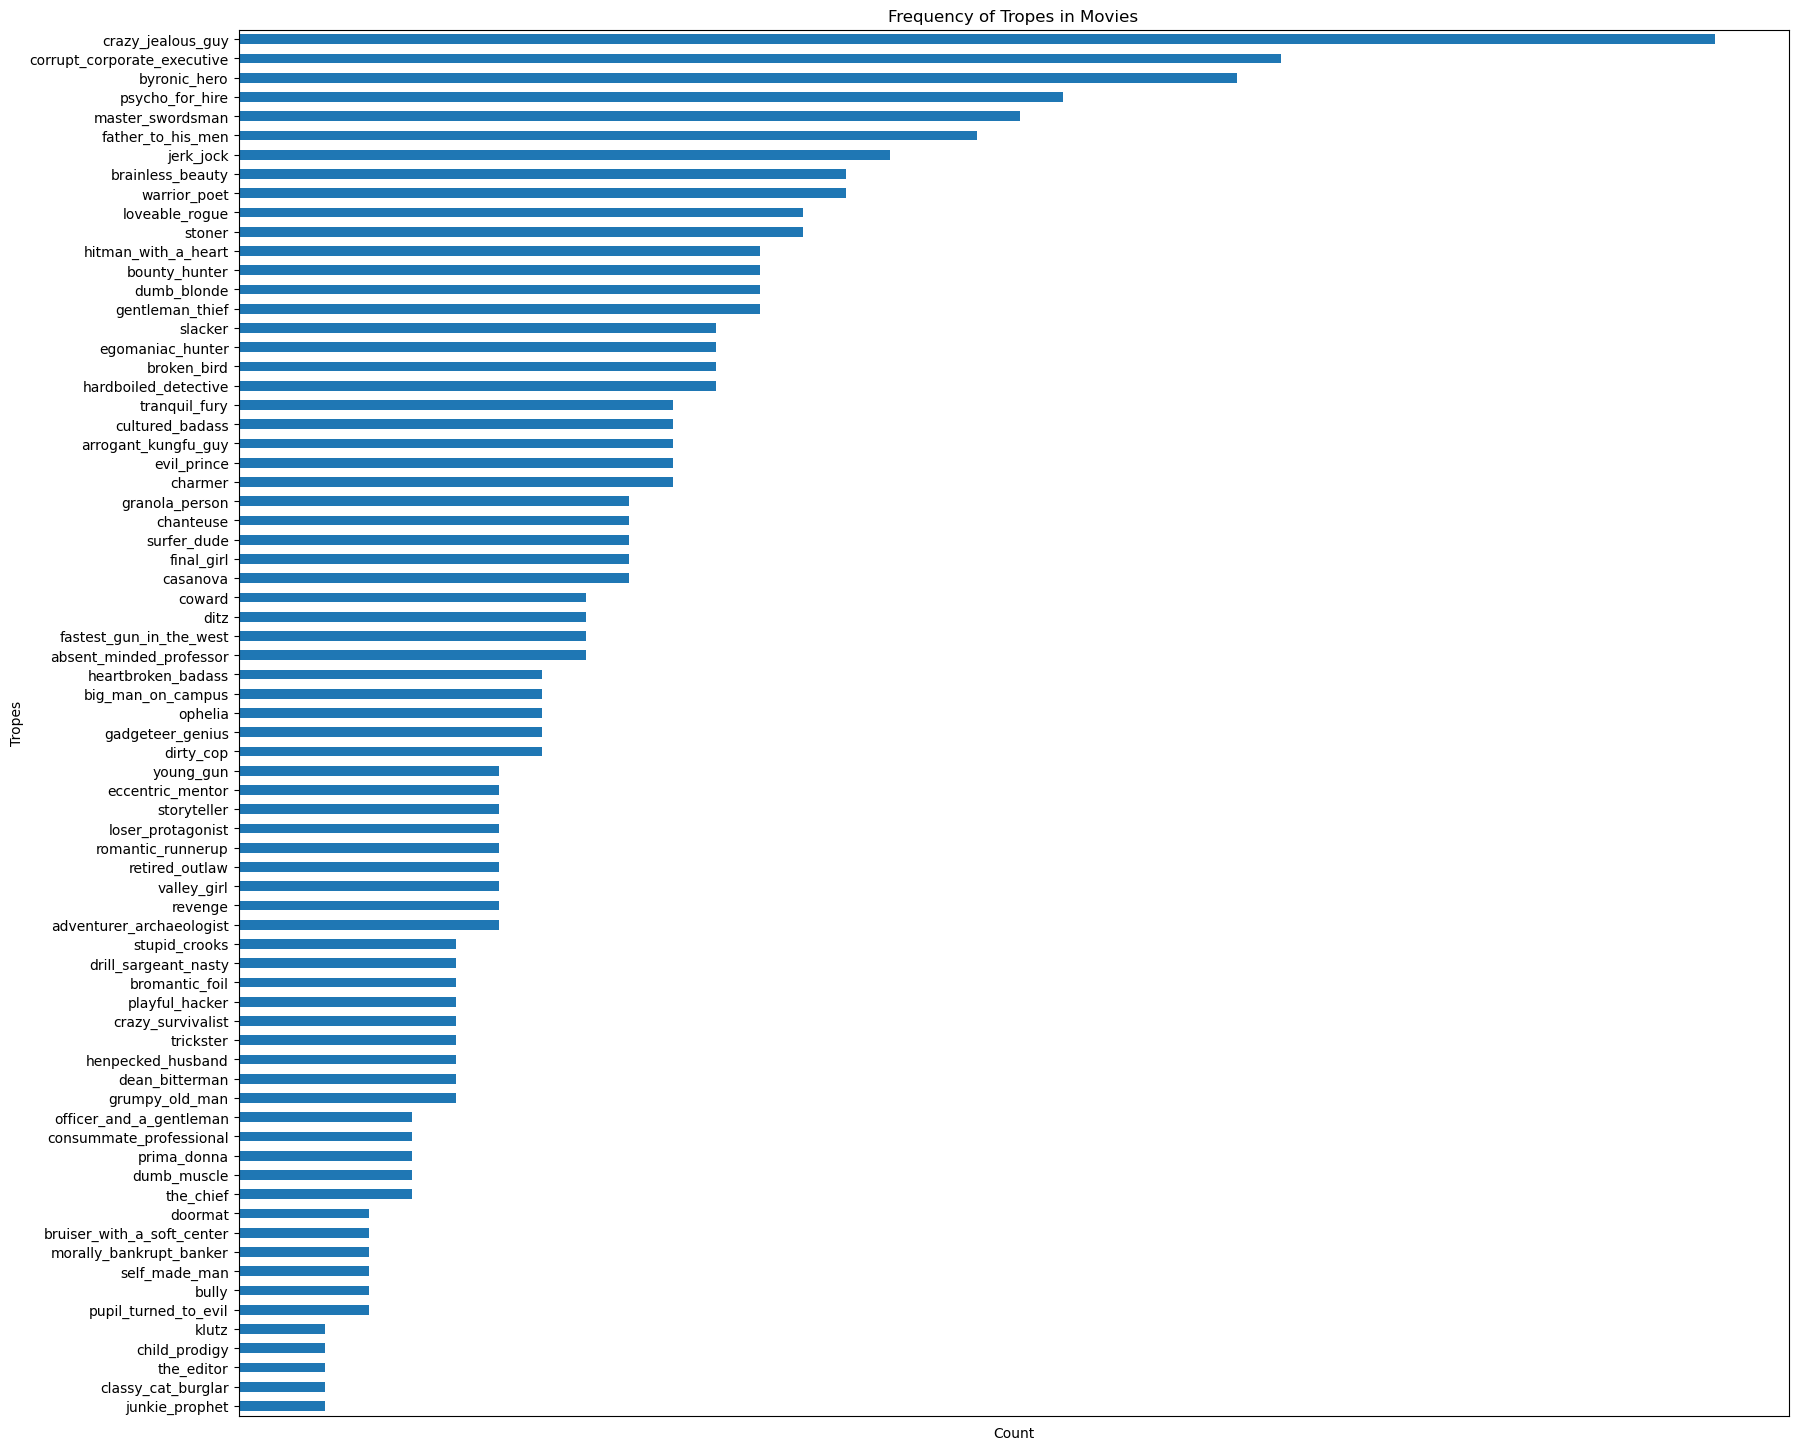

In [47]:
trope_value_counts = movies_personas['trope'].value_counts()

plt.figure(figsize=(20, 18))
trope_value_counts.plot(kind='barh', xticks=[])
plt.xlabel('Count')
plt.ylabel('Tropes')
plt.title('Frequency of Tropes in Movies')
plt.gca().invert_yaxis()
plt.show()

## CMU tropes with actors & characters <a name="part_2_cmu_personas_joined_character"></a>

We merge the actors and characters information we extracted in part I with the tropes from the original paper

In [48]:
cmu_personas = load_personas()
cmu_personas.sample(5)

,freebase_id,wiki_id,movie_name,secondary_name,full_name,token_occurences,estimated_trope,trope_distrib
19699,e1,13254122,What the Daisy Said,she,her,3,2,"[0.0, 0.02, 0.49, 0.01, 0.0, 0.01, 0.0, 0.0, 0..."
8150,e0,11243442,The Missing Postman,he,he,6,12,"[0.0, 0.03, 0.27, 0.03, 0.0, 0.01, 0.01, 0.0, ..."
143494,e23,5558615,Jindabyne,girl,the dead girl,6,12,"[0.0, 0.19, 0.0, 0.0, 0.0, 0.0, 0.0, 0.09, 0.0..."
75058,/m/0cg0__k,24549492,The Hills Run Red,Serina,Serina,22,21,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
90134,e12,2756655,The Black Scorpion,Cosio,Major Cosio,3,35,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [49]:
# Rename mapping columns and perform inner join
cmu_personas = cmu_personas.drop(columns=['secondary_name', 'full_name', "wiki_id"])
cmu_personas = cmu_personas.rename(columns={'freebase_id' : 'freebase_map_id'})
movies_personas_cmu = cmu_personas.merge(actors_characters, on='freebase_map_id')

In [50]:
print(f"We have {len(movies_personas_cmu)} records for characters and their corresponding trope")

We have 31035 records for characters and their corresponding trope


This offers us one possiblity for further analysis, as we have more than 30'000 records

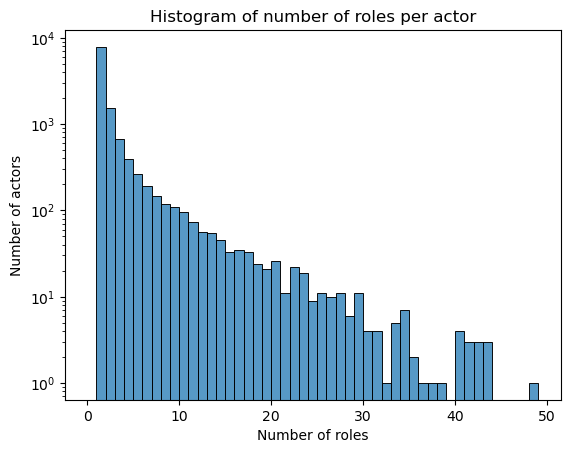

In [51]:
characters_per_actor = movies_personas_cmu[['freebase_actor_id', 'freebase_map_id']].groupby(by='freebase_actor_id').count()
sns.histplot(data=characters_per_actor, x='freebase_map_id', bins=range(50))
plt.yscale('log')
plt.xlabel("Number of roles")
plt.ylabel("Number of actors")
plt.title("Histogram of number of roles per actor")
plt.show()

In [52]:
print(f"Number of actors with 5 roles or more : {len(characters_per_actor[characters_per_actor['freebase_map_id'] >= 5])}")
print(f"Number of actors with less than 5 roles : {len(characters_per_actor[characters_per_actor['freebase_map_id'] < 5])}")

Number of actors with 5 roles or more : 1481
Number of actors with less than 5 roles : 10452


With 5 roles or more, we consider that we can decide "with some confidence" if an actor has a preferred persona or not (under this threshold, data may not be significant enough). There is a reasonable amount of actors for which we gathered enough roles to be confident in our analysis (1481 actors have more than 5 personas). 

Nevertheless, in further methods, we may decide to only keep actors with a number of roles greater than some threshold (to be confident in our metric computations). This may become a source of bias as there is more chance that an actor is successful if he plays in more movies (thus our analysis may become relevant only for "successful" actors and not for actors in general). 

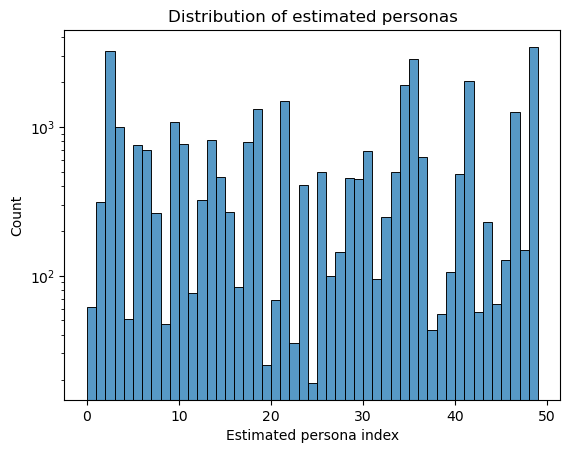

In [53]:
sns.histplot(data=movies_personas_cmu, x='estimated_trope', bins=range(50))
plt.yscale("log")
plt.xlabel('Estimated persona index')
plt.ylabel('Count')
plt.title('Distribution of estimated personas')
plt.show()

The distribution of estimated personas is very heterogeneous, some personas only have one representative ! This can lead to very high variance. For instance suppose for those personas that their representative (movie role) is in a very good movie (according to our movies' success evaluation), then we will deduce that this persona always lead to very good rating and will bias our analysis. We hope that this issue can be mitigated with uncertainty estimation.

Because of all of those possible limitations, to be even more confident with our result, we introduce another way to determine an actor's comfort zone which is based on the movies' genres (presented in next part).

## Summary of results for part II <a name="part_2_summary"></a>
We took the dataframe containing everything related to actors, their features and characters they played in a given movie from the results of part I and added the character tropes distribution from the original CMU paper. We have also defined our preference metrics and showed an example computation on a subsample of data.

In [54]:
actors_characters_personas = movies_personas_cmu.copy()
actors_characters_personas.head()

,freebase_map_id,movie_name,token_occurences,estimated_trope,trope_distrib,wiki_movie_id,freebase_id,release_date,character_name,actor_birth,actor_gender,actor_height,actor_ethnicity,actor_name,release_actor_age,freebase_character_id,freebase_actor_id
0,/m/02vcl4m,Halls of Montezuma,5,35,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.01, 0.0,...",10004330,/m/02pzjvb,1950,Pigeon Lane,1919-02-18,M,1.930,/m/0ffjvd,Jack Palance,30.0,/m/0h5cz0m,/m/02t_w8
1,/m/02tb80v,Halls of Montezuma,3,35,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",10004330,/m/02pzjvb,1950,Lt. Col. Gilfillan,1917-06-18,M,1.854,None,Richard Boone,32.0,/m/0h4z9hs,/m/03c2b1
2,/m/03kvqnf,My Suicidal Sweetheart,4,46,"[0.0, 0.0, 0.21, 0.0, 0.0, 0.0, 0.01, 0.0, 0.0...",10017331,/m/02pzycm,2005-03,Grace,1979-04-04,F,1.600,None,Natasha Lyonne,NaN,/m/0h340qc,/m/032bfz
3,/m/0k52jp,The First of the Few,8,12,"[0.0, 0.02, 0.36, 0.01, 0.0, 0.01, 0.0, 0.0, 0...",1001896,/m/03y7jr,1942,R.J. Mitchell,1893-04-03,M,NaN,/m/041rx,Leslie Howard,NaN,/m/0hhch2q,/m/0lcf1
4,/m/0cgtgj0,Sometimes a Great Notion,6,23,"[0.0, 0.0, 0.09, 0.02, 0.0, 0.0, 0.0, 0.0, 0.0...",10021034,/m/02p_16r,1970-11-12,Andy Stamper,1942-01-05,M,NaN,None,Cliff Potts,28.0,/m/0cgtgj3,/m/0dlc_z


### Saving <a name="part_2_saving"></a>

In [55]:
actors_characters_personas.to_json(os.path.join(SAVE_PATH, "characters_personas.json"), orient='records')

# Part III: Movie-based comfort zones <a name="part_3_movie_based_comfort_zones"></a>

We investigate the possiblity of coming up with comfort zones by analysing movie features for a given actor instead of personas. Defining an actor's comfort zone as such seems at first glance like a reasonable approach. Indeed, even when an actor embodies diverse characters, if they still play for the same type of movies this would raise questions about whether they are truly venturing beyond their comfort zone. Whereas with totally different genres (such as Sport and Action/Adventure movies for instance), we would be more confident that the difference is significant enough to make a difference for the critics.

However this is a much more coarse-grained analysis as differences in actors' tropes may still be really noticeable even for similar genres.

In [56]:
# Load results of part I
actors_characters = pd.read_json(os.path.join(SAVE_PATH, "characters.json"))
movies = pd.read_json(os.path.join(SAVE_PATH, "movies.json"))

# Load results of part II
actors_characters_personas = pd.read_json(os.path.join(SAVE_PATH, "characters_personas.json"))

In [57]:
movies.head()

,tconst,runtimeMinutes,genres,averageRating,numVotes,freebase_id,wiki_movie_id,movie_name,movie_release_date,box_office,movie_languages,movie_countries,movie_genres,plot_summary
0,tt0000009,45,[Romance],5.3,207,/m/02q23xk,10109752,Miss Jerry,1894-10-09,NaN,{'/m/06ppq': 'Silent film'},{'/m/09c7w0': 'United States of America'},"{'/m/02hmvc': 'Short Film', '/m/06ppq': 'Silen...",After finding out that her father is suffering...
1,tt0000147,100,"[Documentary, News, Sport]",5.3,485,/m/0czdh_n,28703057,The Corbett-Fitzsimmons Fight,1897-05-22,100000.0,{},{},{'/m/01z02hx': 'Sports'},The film no longer exists in its entirety; how...
2,tt0000574,70,"[Action, Adventure, Biography]",6.0,856,/m/0120y4,142995,The Story of the Kelly Gang,1906-12-26,NaN,{'/m/02h40lc': 'English Language'},{'/m/0chghy': 'Australia'},"{'/m/0lsxr': 'Crime Fiction', '/m/06ppq': 'Sil...",The Story of the Kelly Gangs tone is of sorrow...
3,tt0000591,90,[Drama],5.0,21,/m/07s67rr,4849466,L'Enfant prodigue,1907-06-20,NaN,{'/m/064_8sq': 'French Language'},{'/m/0f8l9c': 'France'},"{'/m/02hmvc': 'Short Film', '/m/06ppq': 'Silen...",None
4,tt0000679,120,"[Adventure, Fantasy]",5.0,70,/m/0fgfyy,5954041,The Fairylogue and Radio-Plays,1908-09-24,NaN,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"{'/m/06ppq': 'Silent film', '/m/01g6gs': 'Blac...",None


In [58]:
actors_characters.head()

,wiki_movie_id,freebase_id,release_date,character_name,actor_birth,actor_gender,actor_height,actor_ethnicity,actor_name,release_actor_age,freebase_map_id,freebase_character_id,freebase_actor_id
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,None,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,None,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,None,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg


In [59]:
all_data = movies.merge(actors_characters, how="inner", on=["freebase_id", "wiki_movie_id"])

all_data.head()

,tconst,runtimeMinutes,genres,averageRating,numVotes,freebase_id,wiki_movie_id,movie_name,movie_release_date,box_office,...,character_name,actor_birth,actor_gender,actor_height,actor_ethnicity,actor_name,release_actor_age,freebase_map_id,freebase_character_id,freebase_actor_id
0,tt0000147,100,"[Documentary, News, Sport]",5.3,485,/m/0czdh_n,28703057,The Corbett-Fitzsimmons Fight,1897-05-22,100000.0,...,None,1866-09-01,M,NaN,None,James J. Corbett,NaN,/m/0gvztx7,None,/m/037fcq
1,tt0000574,70,"[Action, Adventure, Biography]",6.0,856,/m/0120y4,142995,The Story of the Kelly Gang,1906-12-26,NaN,...,None,None,None,NaN,None,Mr. Marshall,NaN,/m/0bxl509,None,/m/0bxl506
2,tt0000574,70,"[Action, Adventure, Biography]",6.0,856,/m/0120y4,142995,The Story of the Kelly Gang,1906-12-26,NaN,...,None,None,None,NaN,None,Vera Linden,NaN,/m/0bxl501,None,/m/0bxl4__
3,tt0000574,70,"[Action, Adventure, Biography]",6.0,856,/m/0120y4,142995,The Story of the Kelly Gang,1906-12-26,NaN,...,None,None,M,NaN,None,John Tait,NaN,/m/0k6ktp,None,/m/0k6ksg
4,tt0000574,70,"[Action, Adventure, Biography]",6.0,856,/m/0120y4,142995,The Story of the Kelly Gang,1906-12-26,NaN,...,None,None,F,NaN,None,Elizabeth Tait,NaN,/m/0k6ktj,None,/m/0k6ks8


In [60]:
# Potentially merge with IMDB genres, we chose not to
all_data["movie_genres"] = all_data["movie_genres"].apply(lambda dct: list(dct.values()))

In [61]:
# Drop IMDB genres
all_data = all_data.drop(columns=["genres"])

In [62]:
all_data.columns

Index(['tconst', 'runtimeMinutes', 'averageRating', 'numVotes', 'freebase_id',
       'wiki_movie_id', 'movie_name', 'movie_release_date', 'box_office',
       'movie_languages', 'movie_countries', 'movie_genres', 'plot_summary',
       'release_date', 'character_name', 'actor_birth', 'actor_gender',
       'actor_height', 'actor_ethnicity', 'actor_name', 'release_actor_age',
       'freebase_map_id', 'freebase_character_id', 'freebase_actor_id'],
      dtype='object')

## Based on movie genre <a name="part_3_movie_based_comfort_zones_genre"></a>

In [63]:
# Get rid of the freebase_id genre and create an other column simply containing a list of genres
movie_genre_per_actor = all_data[["freebase_actor_id", "actor_name", "movie_genres"]].copy()
movie_genre_per_actor = movie_genre_per_actor.rename(columns={"movie_genres" : "genres_flattened"})

# Group data by actor and aggregate genres by simply putting them in a list
movie_genre_per_actor = movie_genre_per_actor.groupby(["freebase_actor_id", "actor_name"]).agg(list).reset_index()
movie_genre_per_actor["total_movies"] = movie_genre_per_actor["genres_flattened"].apply(len)

# Flatten list of lists
movie_genre_per_actor["genres_flattened"] = movie_genre_per_actor["genres_flattened"].apply(lambda ls: [item for row in ls for item in row])

# Transform list into dictionary of frequencies
movie_genre_per_actor["genres_freq"] = movie_genre_per_actor["genres_flattened"].apply(lambda ls: dict(sorted(dict(Counter(ls)).items(), key=lambda item: item[1], reverse=True)))
movie_genre_per_actor = movie_genre_per_actor.drop("genres_flattened", axis=1)

In [64]:
movie_genre_per_actor.head()

,freebase_actor_id,actor_name,total_movies,genres_freq
0,/m/010p3,Adam Carolla,8,"{'Comedy': 8, 'Romance Film': 5, 'Romantic com..."
1,/m/010q36,Fred Rogers,1,"{'Horror': 1, 'Comedy-drama': 1, 'Fantasy': 1,..."
2,/m/010xjr,Richard Harris,50,"{'Drama': 33, 'Adventure': 19, 'Action': 17, '..."
3,/m/0112yl,Toshiro Mifune,40,"{'Drama': 36, 'Japanese Movies': 28, 'World ci..."
4,/m/011_24,Les Brown,2,"{'Romance Film': 2, 'Comedy': 2, 'Musical': 1,..."


### Distribution of some actors

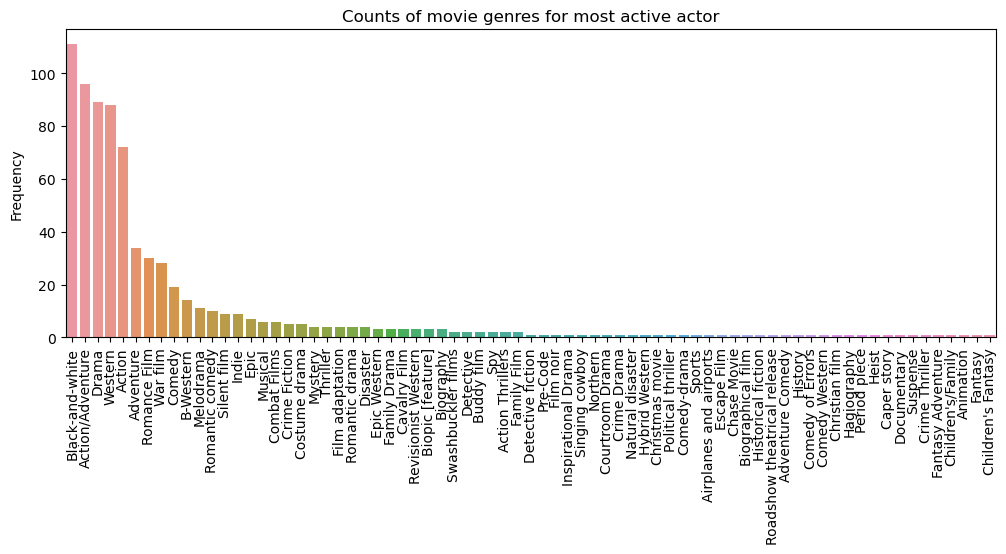

In [65]:
# We check the most active actor distribution, i.e. the one who played the most total movies
top_actors = movie_genre_per_actor.sort_values("total_movies", ascending=False).copy().head()
actor_1 = top_actors["genres_freq"].iloc[0]

plt.figure(figsize=(12, 4))
plt.title('Counts of movie genres for most active actor')
sns.barplot(x=list(actor_1.keys()), y=list(actor_1.values()))
plt.ylabel("Frequency")
plt.xticks(rotation=90)
plt.show()

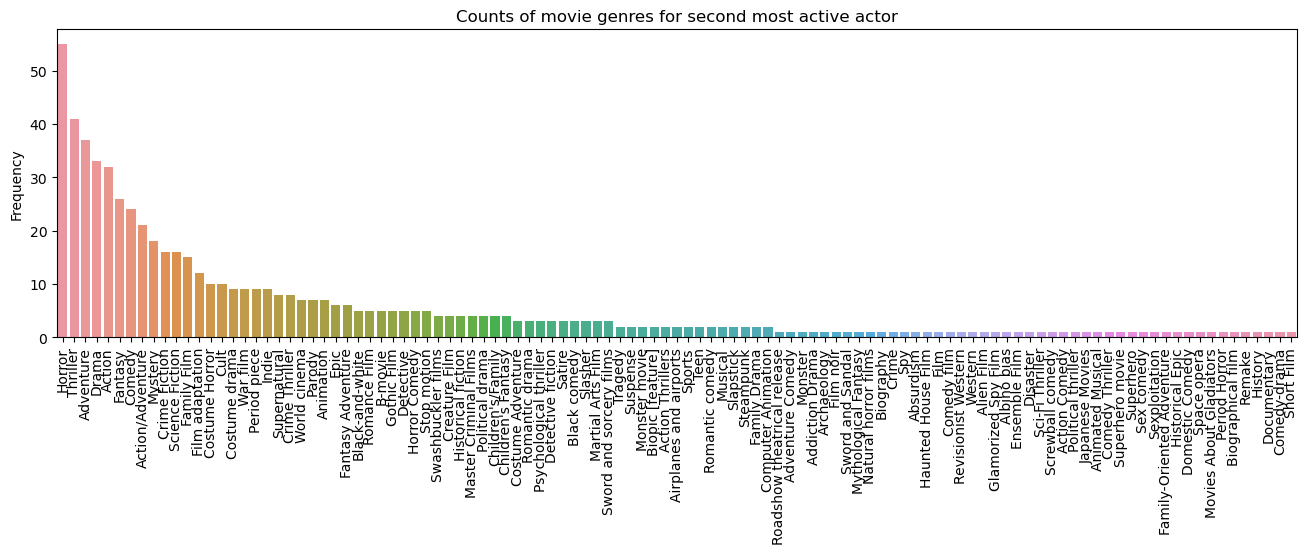

In [66]:
# We check the second most active actor distribution
actor_2 = top_actors["genres_freq"].iloc[1]

plt.figure(figsize=(16, 4))
plt.title('Counts of movie genres for second most active actor')
sns.barplot(x=list(actor_2.keys()), y=list(actor_2.values()))
plt.ylabel("Frequency")
plt.xticks(rotation=90)
plt.show()

### Create genre frequency vector <a name="part_3_genre_freq_vector"></a>

In [67]:
# Compute the set of movie genres
movie_genres = all_data["movie_genres"]
movie_genres_unique = set()
for genres in movie_genres:
    for genre in genres:
        movie_genres_unique.add(genre)
        
# Unique movie genres sorted alphabetically
movie_genres_unique = sorted(list(movie_genres_unique))

# Save genres for later interpretation of vectors
with open(os.path.join(SAVE_PATH, "movie_genres.json"), "w") as outfile:
    json.dump(movie_genres_unique, outfile)

In [68]:
def create_movie_genre_frequency_vector(genres_dict):
    """
    Transforms the dictionary of movie genre counts into a {0,1} vector of frequencies

    Parameters
    ----------
    genres_dict : dictionary
        keys are movie genres and values are counts
        
    Returns
    -------
    list
        The frequency vector
    """
    # Initialize
    freq_dict = {}
    for genre in movie_genres_unique:
        freq_dict[genre] = 0
    
    # Fill our dictionary
    tot_count = 0
    for genre, freq in genres_dict.items():
        tot_count += freq
        freq_dict[genre] += freq
    
    # Compute frequencies
    if tot_count != 0:
        for genre, freq in freq_dict.items():
            freq_dict[genre] /= tot_count
    
    return list(freq_dict.values())

In [69]:
movie_genre_freq_vector = movie_genre_per_actor.copy()
movie_genre_freq_vector["genres_freq"] = movie_genre_per_actor["genres_freq"].apply(create_movie_genre_frequency_vector)
movie_genre_freq_vector = movie_genre_freq_vector.drop(["actor_name"], axis=1)

In [70]:
movie_genre_freq_vector.head()

,freebase_actor_id,total_movies,genres_freq
0,/m/010p3,8,"[0.0, 0.0, 0.02857142857142857, 0.0, 0.0, 0.02..."
1,/m/010q36,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,/m/010xjr,50,"[0.0, 0.0, 0.06854838709677419, 0.0, 0.0080645..."
3,/m/0112yl,40,"[0.0, 0.0, 0.039647577092511016, 0.00440528634..."
4,/m/011_24,2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


### Merge genre frequency with actors and characters <a name="part_3_merge_characters_genre_freq_vector"></a>

In [71]:
actors_characters_personas_genres = actors_characters_personas.merge(movie_genre_freq_vector, on="freebase_actor_id", how="inner").copy()

### Saving <a name="part_3_saving"></a>

In [72]:
# tvtropes_per_actor.to_json(os.path.join(SAVE_PATH, "tvtropes_per_actor.json"), orient='records')
actors_characters_personas_genres.to_json(os.path.join(SAVE_PATH, "characters_personas_genres.json"), orient='records')
actors_characters_personas_genres.head()

,freebase_map_id,movie_name,token_occurences,estimated_trope,trope_distrib,wiki_movie_id,freebase_id,release_date,character_name,actor_birth,actor_gender,actor_height,actor_ethnicity,actor_name,release_actor_age,freebase_character_id,freebase_actor_id,total_movies,genres_freq
0,/m/02vcl4m,Halls of Montezuma,5,35,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00999999...",10004330,/m/02pzjvb,1950,Pigeon Lane,1919-02-18,M,1.93,/m/0ffjvd,Jack Palance,30.0,/m/0h5cz0m,/m/02t_w8,62,"[0.0, 0.0, 0.07661290322580645, 0.004032258064..."
1,/m/0jwnks,Contempt,6,2,"[0.0, 0.0, 0.7699999809, 0.0, 0.0, 0.0, 0.0199...",1109777,/m/046t_0,1963,Jeremy Prokosch,1919-02-18,M,1.93,/m/0ffjvd,Jack Palance,43.0,/m/0by49h9,/m/02t_w8,62,"[0.0, 0.0, 0.07661290322580645, 0.004032258064..."
2,/m/03jrzwk,Monte Walsh,5,30,"[0.0, 0.0, 0.019999999600000002, 0.2899999917,...",12122757,/m/02vqjnv,2003-01-17,Chet Rollins,1919-02-18,M,1.93,/m/0ffjvd,Jack Palance,83.0,/m/0h5cz5s,/m/02t_w8,62,"[0.0, 0.0, 0.07661290322580645, 0.004032258064..."
3,/m/03jrt6y,The Professionals,15,35,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1443103,/m/051_vd,1966-11-02,Jesus Raza,1919-02-18,M,1.93,/m/0ffjvd,Jack Palance,47.0,/m/0h5cz2s,/m/02t_w8,62,"[0.0, 0.0, 0.07661290322580645, 0.004032258064..."
4,/m/0k1qv6,Panic in the Streets,20,41,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1611941,/m/05glbt,1950,Blackie,1919-02-18,M,1.93,/m/0ffjvd,Jack Palance,30.0,/m/0h5cz6_,/m/02t_w8,62,"[0.0, 0.0, 0.07661290322580645, 0.004032258064..."


In [73]:
df = all_data[["freebase_actor_id", "actor_name", "movie_genres", "freebase_map_id", "freebase_id"]]
df.to_json(os.path.join(SAVE_PATH, "actor_movies_with_genre.json"), orient="records")

## Summary of results for part III <a name="part_3_summary"></a>
We have enriched our characters with tropes in part II and genre frequencies in part III. We have setup our two main dataframes for further analysis `movies` and `actors_characters_personas_genres`.

In [74]:
movies.head()

,tconst,runtimeMinutes,genres,averageRating,numVotes,freebase_id,wiki_movie_id,movie_name,movie_release_date,box_office,movie_languages,movie_countries,movie_genres,plot_summary
0,tt0000009,45,[Romance],5.3,207,/m/02q23xk,10109752,Miss Jerry,1894-10-09,NaN,{'/m/06ppq': 'Silent film'},{'/m/09c7w0': 'United States of America'},"{'/m/02hmvc': 'Short Film', '/m/06ppq': 'Silen...",After finding out that her father is suffering...
1,tt0000147,100,"[Documentary, News, Sport]",5.3,485,/m/0czdh_n,28703057,The Corbett-Fitzsimmons Fight,1897-05-22,100000.0,{},{},{'/m/01z02hx': 'Sports'},The film no longer exists in its entirety; how...
2,tt0000574,70,"[Action, Adventure, Biography]",6.0,856,/m/0120y4,142995,The Story of the Kelly Gang,1906-12-26,NaN,{'/m/02h40lc': 'English Language'},{'/m/0chghy': 'Australia'},"{'/m/0lsxr': 'Crime Fiction', '/m/06ppq': 'Sil...",The Story of the Kelly Gangs tone is of sorrow...
3,tt0000591,90,[Drama],5.0,21,/m/07s67rr,4849466,L'Enfant prodigue,1907-06-20,NaN,{'/m/064_8sq': 'French Language'},{'/m/0f8l9c': 'France'},"{'/m/02hmvc': 'Short Film', '/m/06ppq': 'Silen...",None
4,tt0000679,120,"[Adventure, Fantasy]",5.0,70,/m/0fgfyy,5954041,The Fairylogue and Radio-Plays,1908-09-24,NaN,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"{'/m/06ppq': 'Silent film', '/m/01g6gs': 'Blac...",None


In [75]:
actors_characters_personas_genres.head()

,freebase_map_id,movie_name,token_occurences,estimated_trope,trope_distrib,wiki_movie_id,freebase_id,release_date,character_name,actor_birth,actor_gender,actor_height,actor_ethnicity,actor_name,release_actor_age,freebase_character_id,freebase_actor_id,total_movies,genres_freq
0,/m/02vcl4m,Halls of Montezuma,5,35,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00999999...",10004330,/m/02pzjvb,1950,Pigeon Lane,1919-02-18,M,1.93,/m/0ffjvd,Jack Palance,30.0,/m/0h5cz0m,/m/02t_w8,62,"[0.0, 0.0, 0.07661290322580645, 0.004032258064..."
1,/m/0jwnks,Contempt,6,2,"[0.0, 0.0, 0.7699999809, 0.0, 0.0, 0.0, 0.0199...",1109777,/m/046t_0,1963,Jeremy Prokosch,1919-02-18,M,1.93,/m/0ffjvd,Jack Palance,43.0,/m/0by49h9,/m/02t_w8,62,"[0.0, 0.0, 0.07661290322580645, 0.004032258064..."
2,/m/03jrzwk,Monte Walsh,5,30,"[0.0, 0.0, 0.019999999600000002, 0.2899999917,...",12122757,/m/02vqjnv,2003-01-17,Chet Rollins,1919-02-18,M,1.93,/m/0ffjvd,Jack Palance,83.0,/m/0h5cz5s,/m/02t_w8,62,"[0.0, 0.0, 0.07661290322580645, 0.004032258064..."
3,/m/03jrt6y,The Professionals,15,35,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1443103,/m/051_vd,1966-11-02,Jesus Raza,1919-02-18,M,1.93,/m/0ffjvd,Jack Palance,47.0,/m/0h5cz2s,/m/02t_w8,62,"[0.0, 0.0, 0.07661290322580645, 0.004032258064..."
4,/m/0k1qv6,Panic in the Streets,20,41,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1611941,/m/05glbt,1950,Blackie,1919-02-18,M,1.93,/m/0ffjvd,Jack Palance,30.0,/m/0h5cz6_,/m/02t_w8,62,"[0.0, 0.0, 0.07661290322580645, 0.004032258064..."


# Intermezzo : Possible bias and Limitations <a name="part_3_possible_bias_and_limitations"></a>

After exploring the data and performing some initial analyses, some doubt arise about our methods. Unfortunately, we could not clear those doubts with those basic analyses as some of them are too insiduous and require deeper analysis. 

Here are some of the main possible limitations and biases that can occur (and their possible solutions) :

 - Actor *fame* as a confounder :

   Assume that a given actor $A$ have a high preference for a persona $P$. Movies he played as persona $P' \neq P$ tend to under-perform compare to the other movies. This could be explained by the fact that most movies he played as $P'$ were before he became "famous" and as such he was playing roles in movies with much smaller franchise. When he/she became famous, he could take the luxury to decide whether he wanted to play as $P'$ or not.


   **Possible Solution** : Based on the assumption that actors *fame* came with time
   
   - Add a threshold $\alpha$ and only consider movies for actors that have already played in $K \geq \alpha$ movies previously (drop first $\alpha - 1$ movies for 
   each actors)
      
   - Add a third metric $R$ to our model defined as $$R(\text{Actor}, \text{Movie}) = \frac{\text{Number of movies played by actor A prior to M}}{\text{Number of movies played by actor A}}$$

     This would be able to distinguish between the case where $R < \alpha$ and $R > \alpha$ for a given $\alpha$. We could also try to evaluate the strength of this bias by testing the model *with* and *without* this metric. Notice that this is just an extension of the previously defined method. However this extension is more polyvalent than the previos method.
   
 - Impact of certain *personas* on the overall success of the film :

   We could imagine a scenario where the presence of a persona $P$ in our film has a possive effect on the success of this film. As such our model may conclude that actors that have a preference for persona $P$ playing as $P$ have a better effect on the movie success than if he were playing as $P'$ instead.

   **Possible Solution** :

    - Instead of comparing actors that play in their preferred role or not, we should compare how much better an actor playing in his preferred persona
     will improve the movie compared to another actor without particular preference (Let us called this actor the *neutral actor*). We can therefore either
     perform

      - A difference in difference of means between the both (where *neutral actors* are defined by a certain threshold $\alpha$ defined on the metric `1.`).
     
      - Matching between *neutral actors* and *actors* with a preference (however this may end up being complexified by the limited amount)

# Part IV: Analysis <a name="part_4_title"></a>

In this part we will perform the analysis of our dataset and answer the questions formulated in the problematic.

In [2]:
# Load all previous results
movies = pd.read_json(os.path.join(SAVE_PATH, "movies.json"))
movie_genres = pd.read_json(os.path.join(SAVE_PATH, "movie_genres.json"))

actors_characters = pd.read_json(os.path.join(SAVE_PATH, "characters.json"))
actors_characters_personas = pd.read_json(os.path.join(SAVE_PATH, "characters_personas.json"))
actors_characters_personas_genres = pd.read_json(os.path.join(SAVE_PATH, "characters_personas_genres.json"))

actor_movies_with_genre = pd.read_json(os.path.join(SAVE_PATH, "actor_movies_with_genre.json"))

# Rename column for disambiguation purposes
actors_characters_personas_genres = actors_characters_personas_genres.rename(columns={"genres_freq" : "actor_genres_freq"})

In [3]:
# Unpack movie genres
movies["movie_genres"] = movies["movie_genres"].apply(lambda dct: list(dct.values()))

In [4]:
# Get unique list of genres
genres = sorted(list(set([y for xs in actor_movies_with_genre["movie_genres"] for y in xs])))

# Save genres for later interpretation of vectors
genres_one_hot = np.array([np.array(x) for x in actor_movies_with_genre["movie_genres"].apply(
    lambda x: [1 if genre in x else 0 for genre in genres]
)])
genres_freq = genres_one_hot / np.sum(genres_one_hot, axis=1, keepdims=True)
actor_movies_with_genre["genres_freq"] = genres_freq.tolist()

## (0) Some interesting statistics

Before we dive in the analysis, we still wish to present some of the most interesting basic statistics. Some of them come from the data tinkering done in the previous parts. Those statistics are used in the data story. Please note that some of the representations differ because we used plotly plots in the data story, which are not suitable here as they do not appear, hence an imperfect translation was made here.

### Genres distribution

In this subsection, we plot the movie genres distribution of our processed dataset

In [5]:
# Get movie genres, aggregate by unqiuie genre to get frequencies and make a pie chart
df = pd.DataFrame(movies["movie_genres"].explode().reset_index(drop=True))
df["count"] = [1]*len(df)
tot = len(df)

df = df.groupby("movie_genres").agg(np.sum).reset_index()
df["count"] = (df["count"]/tot)*100
df = df.sort_values("count", ascending=False)

# Less than 1% of movies => grouped to other genres
df.loc[df['count'] < 1, 'movie_genres'] = 'Other genres'

# Needed for plotly => matplotlib translation
df = df.groupby("movie_genres").agg(np.sum).reset_index()
df = df.sort_values("count", ascending=False)

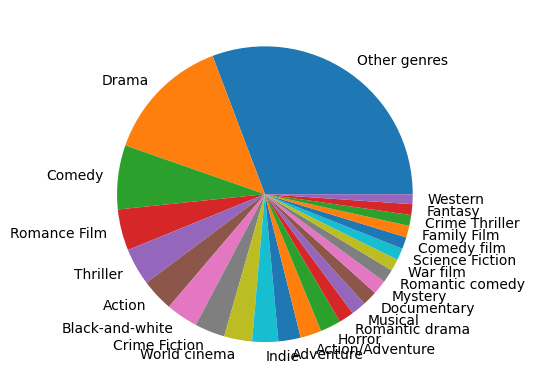

In [6]:
# Pie chart
plt.pie(df['count'], labels = df['movie_genres'])
plt.show()

Unlike the common belief, the **Action** category is only the 5th most represented genre. The two most represented genres are **Drama** and **Comedy** which makes a lot of sense as both of those genres often appear as a secondary genre to a lot of movies. For instance **Romance** and **Drama/Comedy** usually apear together. _Titanic_ is a perfect example of Romance/Drama movie while Rom Com are a genre on its own.

### How big is the box-office? 

To really assess the scale of the movie industry. We tried to compare the box-office of the movies industry to something tangible such as a country's GDP. During our tinkering, we found that the yearly box-office follows Iceland GDP for the past few years!

In [7]:
min_year = 1960
max_year = 2012

movies_df = movies.copy()
movies_df['movie_release_year'] = movies_df[~movies_df['movie_release_date'].isna()]['movie_release_date'].astype(str).str[:4].astype(int)
wrong_dates = movies_df[movies_df['movie_release_year'] < 1800].index
movies_df.loc[wrong_dates]

# A movie that has the release date 1010. We fix the typo to 2010
movies_df.loc[wrong_dates, 'movie_release_year']= 2010
movies_df.loc[wrong_dates, 'movie_release_date'] ='2010-12-02'

movies_df = movies_df[["movie_release_year", "box_office"]]

groupped = movies_df.groupby("movie_release_year").agg(sum).reset_index()
groupped = groupped.loc[(groupped["movie_release_year"] >= 1960) & (groupped["movie_release_year"] <= 2012)]

In [8]:
# Retrieve GDP data
GDP_PATH = "data/gdp/gdp_data.csv"
gdp_df = pd.read_csv(GDP_PATH)
iceland_gdp = gdp_df[gdp_df["Country Name"] == "Iceland"]
iceland_gdp = iceland_gdp[["Year", "Value"]]

In [9]:
# Merge both collections
merged_gdp_box_office = groupped.merge(iceland_gdp, how="inner", left_on="movie_release_year", right_on="Year")
merged_gdp_box_office = merged_gdp_box_office.drop(["Year"], axis=1)

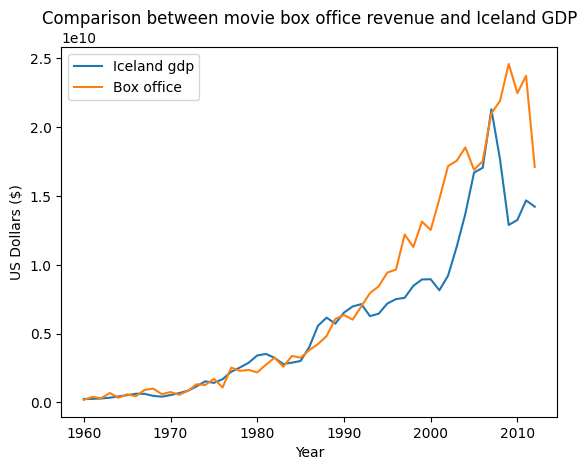

In [10]:
# Plot
plt.plot(merged_gdp_box_office["movie_release_year"], merged_gdp_box_office["Value"], label="Iceland gdp")
plt.plot(merged_gdp_box_office["movie_release_year"], merged_gdp_box_office["box_office"], label="Box office")
plt.xlabel("Year")
plt.ylabel("US Dollars ($)")
plt.title("Comparison between movie box office revenue and Iceland GDP")
plt.legend()

We notice that in the last couple of years (after the 2008 financial crisis), Iceland's GDP took a big hit while the box-office revenue continued to skyrocket. 🚀

### CMU personas interpretation

The CMU analysis provides an automated way to extract personas from movies summaries. We would like to take a closer look at those generated personas. To interpret them, we use word2vec to visualize the most represented terms (for agent, patient and modifiee) of some interesting personas. The TSNE dimensionality reduction is used on the word vectors to plot the words in 2 dimensions

In [11]:
import json
import gensim.downloader
from sklearn.manifold import TSNE

with open("data/cmu/personas/personas_words.json") as f:
    frequent_terms = json.load(f)
    
glove_vectors = gensim.downloader.load('glove-wiki-gigaword-50')

In [12]:
N_PERSONAS = 50

def plot_persona_words(word_type):
    cluster_points = dict()
    word_vectors = []
    word_personas = []
    word_labels = []

    # Use glove vectors
    for p in range(1, N_PERSONAS + 1):
        words = frequent_terms[str(p)][word_type]

        for w in words:
            word_vectors.append(glove_vectors[w])
            word_personas.append(str(p))
            word_labels.append(w)

    # Call TSNE
    tsne = TSNE(n_components=2, learning_rate='auto', random_state=10,
                       init='random', perplexity=3, metric='cosine').fit_transform(np.array(word_vectors))

    # Plot resulting reduction
    df = pd.DataFrame.from_dict({'tsne_1' : tsne[:,0], 'tsne_2' : tsne[:,1], 'persona' : word_personas, 'label' : word_labels})
    nice_personas = {"14", "5", "27", "40", "43"}
    df = df[df["persona"].isin(nice_personas)]
    fig = sns.scatterplot(df, x="tsne_1", y="tsne_2", hue="persona")
    plt.title(f"TSNE reduction of personas {word_type} vectors")
    plt.show()

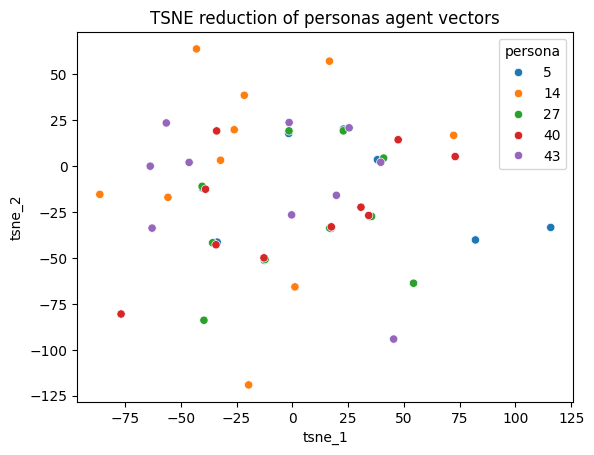

In [13]:
plot_persona_words("agent")

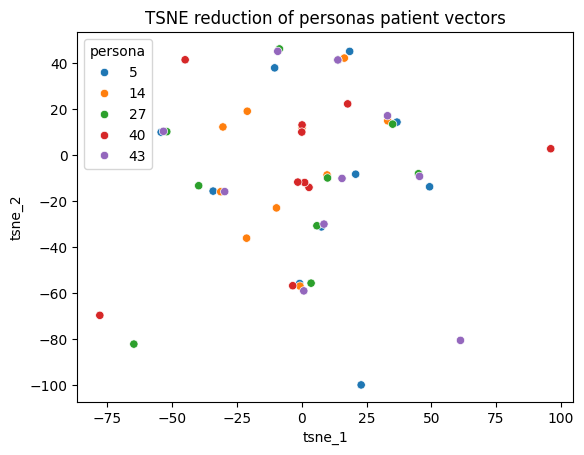

In [14]:
plot_persona_words("patient")

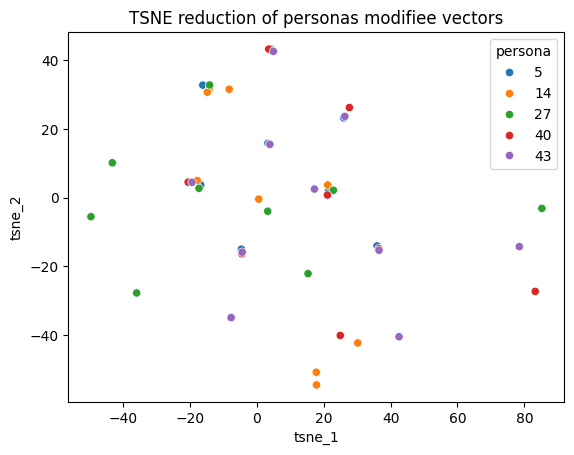

In [15]:
plot_persona_words("modifiee")

### Statistics about the CMU generated personas

In this section, we present some statistics about the generated personas

In [16]:
tropes_distributions = actors_characters_personas["trope_distrib"].apply(np.array).to_numpy()

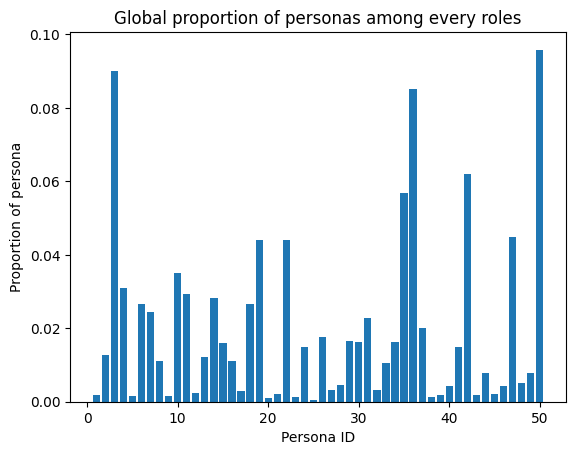

In [17]:
plt.bar(range(1, N_PERSONAS + 1), tropes_distributions.mean(axis=0))
plt.title("Global proportion of personas among every roles")
plt.ylabel("Proportion of persona")
plt.xlabel("Persona ID")
plt.show()

For our data story, we compare the global distribution to the distribution of a specific actor. We chose an actor who has a reputation to always play the "bad guy": Christopher Lee. He is the person behind Count Dooku, Saruman and Dracula!

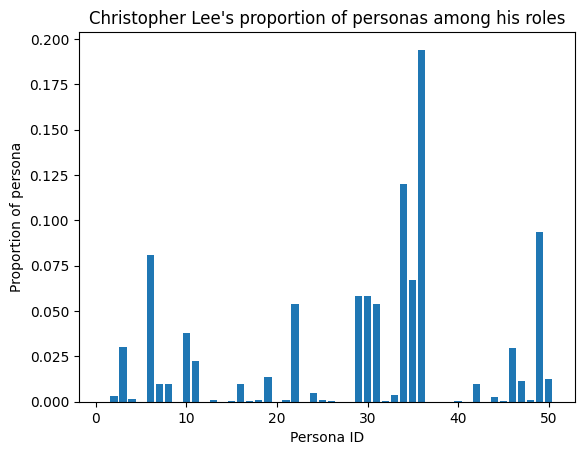

In [18]:
lee_distributions = actors_characters_personas[actors_characters_personas["actor_name"] == "Christopher Lee"]["trope_distrib"].apply(lambda row : np.array(row)).to_numpy()
plt.bar(range(1, 51), lee_distributions.mean(axis=0))
plt.title("Christopher Lee's proportion of personas among his roles")
plt.ylabel("Proportion of persona")
plt.xlabel("Persona ID")
plt.show()

In [21]:
from tabulate import tabulate

top_words = list(frequent_terms[str(34)].values())
top_words = list(map(list, zip(*top_words)))

print("Top words for Persona 34")
print(tabulate(top_words, headers=frequent_terms[str(34)].keys(), tablefmt="fancy_grid"))

Top words for Persona 34
╒══════════╤═══════════╤════════════╕
│ agent    │ patient   │ modifiee   │
╞══════════╪═══════════╪════════════╡
│ flee     │ work      │ worker     │
├──────────┼───────────┼────────────┤
│ plan     │ run       │ terrorist  │
├──────────┼───────────┼────────────┤
│ reveal   │ fall      │ able       │
├──────────┼───────────┼────────────┤
│ get      │ know      │ black      │
├──────────┼───────────┼────────────┤
│ hide     │ live      │ partner    │
├──────────┼───────────┼────────────┤
│ impale   │ impale    │ lover      │
├──────────┼───────────┼────────────┤
│ force    │ force     │ dead       │
├──────────┼───────────┼────────────┤
│ strangle │ strangle  │ former     │
├──────────┼───────────┼────────────┤
│ throw    │ throw     │ angry      │
├──────────┼───────────┼────────────┤
│ appear   │ appear    │ new        │
╘══════════╧═══════════╧════════════╛


A couple of personas are more represented in Christopher Lee's persona spectrum (compared to the general distribution) such as Persona 34. Some words like "impale", "strangle", "flee" evoke some of his most iconic roles like Dracula!

## (1) What is the proportion of actors that tend to play the same type of movies/personas ?  
## (3) Do actors exhibit a recurring persona accross the characters they play ?

### First Approach: Herfindahl-Hirschman Index (HHI)

**Herfindahl-Hirschman Index (HHI)**:  
Can be used to measure to measure market concentration. A high HHI would indicate an actor frequently plays in the same genre/ the same persona, whereas a low HHI would indicate a more diverse range.

$$
    \text{HHI}(a) = \sum_{i=1}^N (F_{i;a})^2
$$

Where $F_{i;a}$ is the frequency at which actor $a$ play genre/persona $i$. If the frequency is equally distributed among each role/persona then the HHI index is going to be close to $\frac{1}{N}$ while if a clear preferrence can be observed then the HHI index is going to be high (close to $1$)

In [22]:
def calculate_hhi(frequencies):
    # Normalize the frequencies
    total = sum(frequencies)
    normalized_freq = [f/total for f in frequencies] if total > 0 else frequencies

    # Calculate HHI
    hhi = sum(f**2 for f in normalized_freq)
    return hhi

### Second Approach: Use our defined preference metric

- **Mutual Information Preference (MIP)**:

   The Mutual Information metric captures the information gain about the actor's persona choices relative to the global persona distribution. This metric can also be applied on genres.
   $$\text{MIP}(\text{actor}) = \frac{ H(\text{Persona}) - H(\text{Persona} | \text{Actor} = \text{actor}) }{H(\text{Persona})}$$
      
   This metric has the following property
   - If the actor $a$ always plays the same persona, then $\text{pref}(a) = 1$
   - If the actor $a$ plays each persona with the same distribution than the global distribution, then $\text{pref}(a) = 0$
   - If the actor$a$ play each persona with a more uniform distribution than the global distribution, then $\text{pref}(a) < 0$

In [23]:
def calculate_mip(frequencies, h_prior):
    # Build the posteriori distribution (conditionned on actor)
    h_posteriori = scipy.stats.entropy(frequencies, base=2)

    return (h_prior - h_posteriori) / h_prior

### Movie genres

In [24]:
# This parameter allows us to filter out actors that did not play many movies
MINIMUM_NUM_MOVIES_GENRES = 3
mask_movies_genre = actors_characters_personas_genres["total_movies"] >= MINIMUM_NUM_MOVIES_GENRES

print("Dropping {:.2f}% of actor-characters pairs ({} remaining)".format(100 - 100 * sum(mask_movies_genre) / len(mask_movies_genre), sum(mask_movies_genre)))

Dropping 11.90% of actor-characters pairs (27342 remaining)


#### HHI

In [25]:
actors_characters_personas_genres["hhi_genre"] = actors_characters_personas_genres["actor_genres_freq"].apply(calculate_hhi)

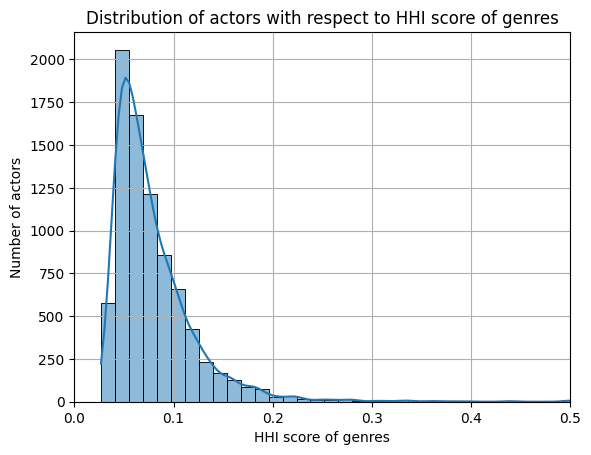

In [26]:
sns.histplot(actors_characters_personas_genres.drop_duplicates("freebase_actor_id")[mask_movies_genre]["hhi_genre"], bins=50, kde=True)
plt.xlabel("HHI score of genres")
plt.ylabel("Number of actors")
plt.xlim([0,0.5])
plt.title("Distribution of actors with respect to HHI score of genres")
plt.grid()
plt.show()

#### MIP

In [27]:
# Retrieve movies for which we have characters
movies_from_characters = actors_characters.wiki_movie_id.unique()
movies_with_characters = movies[movies.wiki_movie_id.isin(movies_from_characters)].reset_index(drop = True).copy()
movies_with_characters = movies_with_characters[movies_with_characters["movie_genres"].apply(len) > 0].reset_index(drop = True)

# Retrieve global genre distribution
all_movie_genres = movies_with_characters["movie_genres"]

# Compute the entropy of movie genres
movie_frequency_genre = dict(Counter(all_movie_genres.explode().to_list()))
movie_genre_prior_h = scipy.stats.entropy(list(movie_frequency_genre.values()), base=2)
print("Prior entropy of movie genres: {:.2f}".format(movie_genre_prior_h))

Prior entropy of movie genres: 5.92


In [28]:
actors_characters_personas_genres["mip_genre"] = actors_characters_personas_genres["actor_genres_freq"].apply(lambda genre_freq: calculate_mip(genre_freq, movie_genre_prior_h))

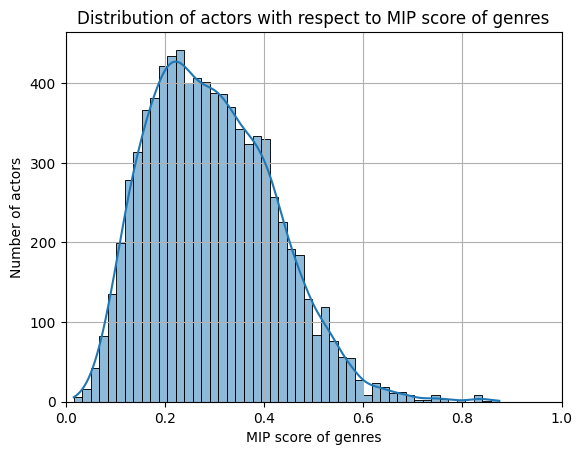

In [29]:
sns.histplot(actors_characters_personas_genres.drop_duplicates("freebase_actor_id")[actors_characters_personas_genres["total_movies"] >= MINIMUM_NUM_MOVIES_GENRES]["mip_genre"], bins=50, kde=True)
plt.xlabel("MIP score of genres")
plt.ylabel("Number of actors")
plt.xlim([0,1])
plt.title("Distribution of actors with respect to MIP score of genres")
plt.grid()
plt.show()

### Movie personas

In [30]:
# This parameter allows us to filter out actors that did not play many movies
MINIMUM_NUM_MOVIES_PERSONAS = 3
mask_movies_personas = actors_characters_personas_genres["total_movies"] >= MINIMUM_NUM_MOVIES_PERSONAS

print("Dropping {:.2f}% of actor-characters pairs ({} remaining)".format(100 - 100 * sum(mask_movies_personas) / len(mask_movies_personas), sum(mask_movies_personas)))

Dropping 11.90% of actor-characters pairs (27342 remaining)


#### HHI

In [31]:
aggregated_trope_distrib = actors_characters_personas_genres[["freebase_actor_id", "trope_distrib"]].groupby("freebase_actor_id").agg(lambda xs: np.mean(np.array([x for x in xs]), axis=0)).rename(columns={"trope_distrib": "actor_trope_distrib"}).reset_index()

# Merge the result back into the main dataframe
actors_characters_personas_genres = actors_characters_personas_genres.merge(aggregated_trope_distrib, on="freebase_actor_id")

In [32]:
# Compute the HHI of tropes
actors_characters_personas_genres["hhi_trope"] = actors_characters_personas_genres["actor_trope_distrib"].apply(calculate_hhi)

In [33]:
# Aggregate per actor
average_hhi_per_actor = actors_characters_personas_genres[mask_movies_personas][["freebase_actor_id", "hhi_trope"]]\
    .groupby("freebase_actor_id")\
    .agg("mean")\
    .reset_index()

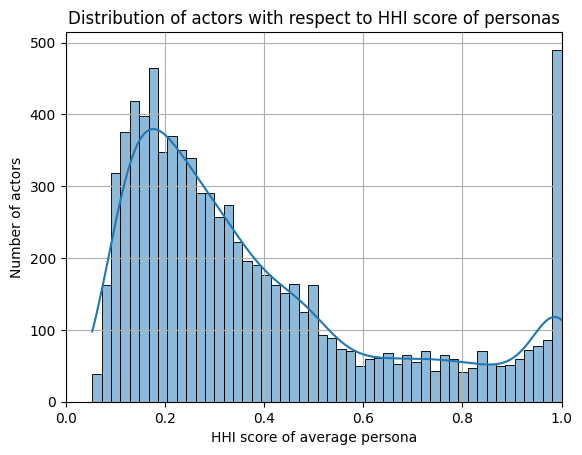

In [34]:
sns.histplot(average_hhi_per_actor["hhi_trope"], bins=50, kde=True)
plt.xlabel("HHI score of average persona")
plt.ylabel("Number of actors")
plt.xlim([0,1])
plt.title("Distribution of actors with respect to HHI score of personas")
plt.grid()
plt.show()

#### MIP

In [35]:
# Retrieve all distinct character tropes
all_character_tropes = np.array([list(x) for x in actors_characters_personas.copy().drop_duplicates("freebase_character_id")["trope_distrib"]])

# Reconstruct global distribution
global_trope_distribution = np.mean(all_character_tropes, axis=0)

# Compute the entropy of personas
character_tropes_prior_h = scipy.stats.entropy(global_trope_distribution, base=2)
print("Prior entropy of character tropes: {:.2f}".format(character_tropes_prior_h))

Prior entropy of character tropes: 4.83


In [36]:
actors_characters_personas_genres["mip_trope"] = actors_characters_personas_genres["actor_trope_distrib"].apply(lambda trope_distrib: calculate_mip(trope_distrib, character_tropes_prior_h))

In [37]:
# Aggregate per actor
average_mip_per_actor = actors_characters_personas_genres[mask_movies_personas][["freebase_actor_id", "mip_trope"]]\
    .groupby("freebase_actor_id")\
    .agg("mean")\
    .reset_index()

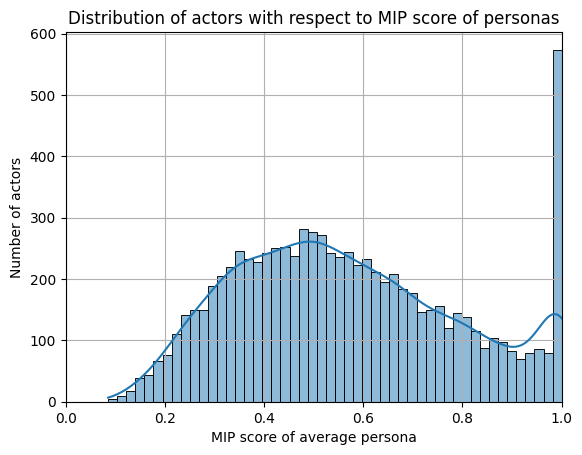

In [38]:
sns.histplot(average_mip_per_actor["mip_trope"], bins=50, kde=True)
plt.xlabel("MIP score of average persona")
plt.ylabel("Number of actors")
plt.xlim([0,1])
plt.title("Distribution of actors with respect to MIP score of personas")
plt.grid()
plt.show()

### Summary & Interpretation

In [39]:
# Notice the 4 new columns with scores and the actor_trope_distribution
actors_characters_personas_genres.head()

,freebase_map_id,movie_name,token_occurences,estimated_trope,trope_distrib,wiki_movie_id,freebase_id,release_date,character_name,actor_birth,...,release_actor_age,freebase_character_id,freebase_actor_id,total_movies,actor_genres_freq,hhi_genre,mip_genre,actor_trope_distrib,hhi_trope,mip_trope
0,/m/02vcl4m,Halls of Montezuma,5,35,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00999999...",10004330,/m/02pzjvb,1950,Pigeon Lane,1919-02-18,...,30.0,/m/0h5cz0m,/m/02t_w8,62,"[0.0, 0.0, 0.0766129032, 0.0040322581, 0.00403...",0.043119,0.124171,"[0.0, 0.00043478260000000003, 0.03913043399130...",0.08218,0.17216
1,/m/0jwnks,Contempt,6,2,"[0.0, 0.0, 0.7699999809, 0.0, 0.0, 0.0, 0.0199...",1109777,/m/046t_0,1963,Jeremy Prokosch,1919-02-18,...,43.0,/m/0by49h9,/m/02t_w8,62,"[0.0, 0.0, 0.0766129032, 0.0040322581, 0.00403...",0.043119,0.124171,"[0.0, 0.00043478260000000003, 0.03913043399130...",0.08218,0.17216
2,/m/03jrzwk,Monte Walsh,5,30,"[0.0, 0.0, 0.019999999600000002, 0.2899999917,...",12122757,/m/02vqjnv,2003-01-17,Chet Rollins,1919-02-18,...,83.0,/m/0h5cz5s,/m/02t_w8,62,"[0.0, 0.0, 0.0766129032, 0.0040322581, 0.00403...",0.043119,0.124171,"[0.0, 0.00043478260000000003, 0.03913043399130...",0.08218,0.17216
3,/m/03jrt6y,The Professionals,15,35,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1443103,/m/051_vd,1966-11-02,Jesus Raza,1919-02-18,...,47.0,/m/0h5cz2s,/m/02t_w8,62,"[0.0, 0.0, 0.0766129032, 0.0040322581, 0.00403...",0.043119,0.124171,"[0.0, 0.00043478260000000003, 0.03913043399130...",0.08218,0.17216
4,/m/0k1qv6,Panic in the Streets,20,41,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1611941,/m/05glbt,1950,Blackie,1919-02-18,...,30.0,/m/0h5cz6_,/m/02t_w8,62,"[0.0, 0.0, 0.0766129032, 0.0040322581, 0.00403...",0.043119,0.124171,"[0.0, 0.00043478260000000003, 0.03913043399130...",0.08218,0.17216


#### HHI

**Interpretation:**
- Peak Near Zero: A concentration of actors with low HHI scores suggests that most actors in your dataset play a variety of roles and are not limited to a specific genre.
- Long Tail: The long tail towards the higher HHI scores suggests that while there are actors who are polarized, they are in the minority.
- Spike near one: The spike on the value 1 on the personas HHI graph is due to actors whose average persona contains no information i.e their persona distribution resembles a dirac delta. This can happend for actors with very few movies in which they play on of the extracted personas from LDA

**Conclusions:**
- Diversity in Roles: There is a significant diversity in the roles that actors play, with many taking on a wide range of genres.
- Limited Typecasting: Only a small proportion of actors may be typecast into specific genres, as indicated by the tail of the distribution.

#### MIP

**Benefits w.r.t HHI:**
- This approach does not assume anything about the prior distribution of roles and genres, it computes it.

**Interpretation:**
- For genres: The bell curve around 0.25 shows that actors are pretty varied in the genres of movies they play. The tail of the distribution is not heavy and there are very few outliers.
- For personas: We also have a bell curve but this time it is far more spread out and also centered on 0.5. This indicates that actors have average personas that are more polarized than genres.
- Spike near one: The spike on the value 1 on the personas graph is due to actors whose average persona contains no information i.e their persona distribution resembles a dirac delta. This can happend for actors with very few movies in which they play one of the extracted personas from LDA (one-hot persona distribution vector).

**Limitation:**
- Since we perform the analysis *per actor* and the personas are *per character* we need to have an aggregation step. We decided to une an average of the personas feature vector on which we applied the MIP, but we inevitably lose fine-grained infromation in the process.

**Conclusions:**
- Personas are far more polarized than genres and a big fraction of actors have an average persona polarized towards specific personas

### Visualizing genre distribution of most polarized actors

In [110]:
# Retrieve actors with more than 10 movies
visualize_actor = actors_characters_personas_genres.drop_duplicates("freebase_actor_id").reset_index(drop=True).copy()
visualize_actor = visualize_actor[visualize_actor.total_movies > 10].sort_values("mip_genre",ascending=False)[["actor_name", "actor_genres_freq", "total_movies"]].reset_index(drop=True)

# Top 5 most polarized actors
for i in range(5):
    actor_rank = i
    actor_data = visualize_actor.iloc[actor_rank]

    genres_freq_actor = dict(zip(movie_genres[0].to_list(), visualize_actor.iloc[actor_rank]["actor_genres_freq"]))
    genres_freq_actor_filtered = dict([(e[0],e[1]) for e in genres_freq_actor.items() if e[1]])

    sns.barplot(x=genres_freq_actor_filtered.keys(), y=genres_freq_actor_filtered.values())
    plt.ylabel("Frequency")
    plt.xticks(rotation=90)
    plt.title(f"Genre distribution for {actor_data['actor_name']}")
    plt.show()

AttributeError: 'bool' object has no attribute 'all'

### Visualizing genre distribution of some famous hollywood actors

In [111]:
# Get genre distribution from famous actors
# They decrease in polarization

famous_actors = ["Johnny Depp", "Tom Cruise", "Julia Roberts", "Emma Watson"]
ilocs_of_interest = visualize_actor[visualize_actor.actor_name.isin(famous_actors)].index.to_list()

for actor_rank in ilocs_of_interest:
    actor_data = visualize_actor.iloc[actor_rank]

    genres_freq_actor = dict(zip(movie_genres[0].to_list(), visualize_actor.iloc[actor_rank]["actor_genres_freq"]))
    genres_freq_actor_filtered = dict([(e[0],e[1]) for e in genres_freq_actor.items() if e[1] > 0.01]) #Remove some noise
    
    # Successive plots
    sns.barplot(x=genres_freq_actor_filtered.keys(), y=genres_freq_actor_filtered.values())
    plt.ylabel("Frequency")
    plt.xticks(rotation=90)
    plt.title(f"Genre distribution for {actor_data['actor_name']}")
    plt.show() 

AttributeError: 'bool' object has no attribute 'all'

### Binning according to MIP

In [112]:
# Define the MIP score thresholds for low, medium, and high typecasting
low_threshold = 0.2
medium_threshold = 0.5
high_threshold = 0.8

# Create a new column for MIP Category
binned_actors = pd.cut(actors_characters_personas_genres.drop_duplicates("freebase_actor_id")['mip_trope'], 
                                                           bins=[0, low_threshold, medium_threshold, high_threshold, 1], 
                                                           labels=['Low', 'Medium-Low', 'Medium-High', 'High'])

category_counts = binned_actors.value_counts()

# Calculate the proportions
category_proportions = category_counts / len(binned_actors)

category_proportions

Medium-High    0.399983
Medium-Low     0.354144
High           0.228526
Low            0.017347
Name: mip_trope, dtype: float64

-  1.73% of actors have a very low MIP score, indicating they have a range of roles simialar to the global distribution.

-  35.42% of actors fall into the medium low category, which means they have some level of specialization but not to the extent that they are being strongly typecast. These actors may have a few genres they appear in more frequently than others, but they still have a mix in their filming carrer.

-  39.98% of actors fall into the medium high category, which means they have a relatively high level of specialization and are oftentime casted for the same type of characters. These actors have a polarized filming carrer.

- 22.85% of actors have a high MIP score, above 0.8, suggesting that they tend to play roles in a limited range of personas,  with a large level of typecasting. However, if we remove the actors with an MIP score equal to one, (that played only the same stereotypical character) this fraction drops to 14.8%, which is still realtively high, leading us to conclude that a large portion of actors are typecast.

## (2) When did an actor start to play similar characters ?

The idea of this part is to determine if there are tends in the progression of tropes preferences in actors lifetime. The hypothesis we want to test for is that young actor don't have a saying in what role they want to play. However when casting actors that are very famous, the general public (and therefore the producer) already have an idea on which role this actor will play in. 

In [113]:
# Let's take what we need from out collection and keep busy actors with more than 20 roles
time_analysis = actors_characters_personas_genres[["freebase_actor_id", "freebase_id", "actor_genres_freq", "trope_distrib", "release_actor_age", "total_movies"]].copy()
time_analysis = time_analysis[~time_analysis["release_actor_age"].isna()]
time_analysis = time_analysis[time_analysis["release_actor_age"] > 0]
time_analysis = time_analysis[time_analysis["total_movies"] > 20]

### Tropes

In [114]:
# Compute MIP for all characters
time_analysis_trope = time_analysis[["freebase_actor_id", "trope_distrib", "release_actor_age"]]
time_analysis_trope["trope_distrib"] = time_analysis_trope["trope_distrib"].apply(lambda trope_distrib: calculate_mip(trope_distrib, character_tropes_prior_h))
time_analysis_trope = time_analysis_trope.groupby("freebase_actor_id").agg(list).reset_index()

In [115]:
# Zip MIP scores with actor age
def zip_trope_age(row):
    trope_ls = row["trope_distrib"]
    age_ls = row["release_actor_age"]
    return sorted(list(zip(age_ls, trope_ls)), key=lambda a: a[0])

In [116]:
time_analysis_trope["zipped"] = time_analysis_trope.apply(zip_trope_age, axis=1)
time_analysis_trope = time_analysis_trope.drop(["freebase_actor_id", "trope_distrib", "release_actor_age"], axis=1)

In [117]:
# For each character entry when an actor played multiple movies in one year, we average the personas for that year
def merge_entry_same_age(test):
    x = [w[0] for w in test]
    y = [w[1] for w in test]
    df = pd.DataFrame({"age": x, "mip":y})
    df = df.groupby("age").agg(np.mean).reset_index()
    return [(t[1], t[2]) for t in df.to_records()]

In [118]:
time_analysis_trope["zipped"] = time_analysis_trope["zipped"].apply(merge_entry_same_age)

In [119]:
# Separate the zipped column
time_analysis_trope = time_analysis_trope[time_analysis_trope["zipped"].apply(len) > 10]
time_analysis_trope = pd.DataFrame({"zipped": time_analysis_trope["zipped"].explode()})
time_analysis_trope["age"] = time_analysis_trope["zipped"].apply(lambda x: int(x[0]))
time_analysis_trope["mip"] = time_analysis_trope["zipped"].apply(lambda x: x[1])
time_analysis_trope = time_analysis_trope.drop("zipped", axis=1).reset_index(drop=True)

In [120]:
# Check the support for each age group
time_analysis_trope_counts = time_analysis_trope["age"].value_counts().reset_index().sort_values("age")
plt.plot(time_analysis_trope_counts["age"], time_analysis_trope_counts["count"])
plt.xlabel("Age")
plt.ylabel("Number of records")
plt.title("Number of records over age")
plt.show()

KeyError: 'count'

In [ ]:
# We average the MIP of all characters on a given year
time_analysis_trope = time_analysis_trope.groupby("age").agg(np.median).reset_index()

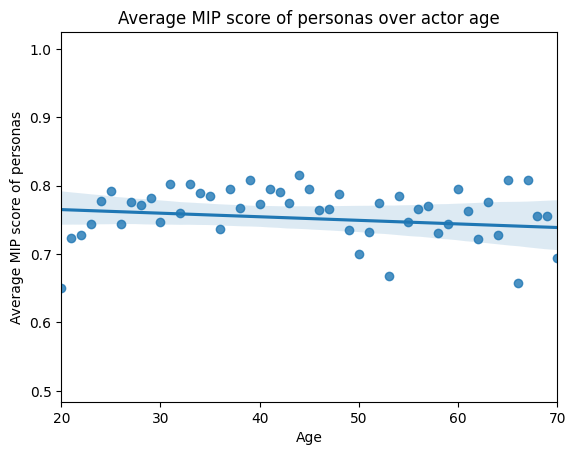

In [ ]:
# We limit the graph where we have good support, between 20 and 70 years old actors
plt.xlim([20,70])
sns.regplot(x = time_analysis_trope["age"], y = time_analysis_trope["mip"])
plt.xlabel("Age")
plt.ylabel("Average MIP score of personas")
plt.title("Average MIP score of personas over actor age")
plt.show()

This graph clearly shows that there seems to be not relationship between and actor's age and his average MIP score. The hypothesis that young actors don't have a saying in what role they want to play is disproven in this method. However, we have to notice that the number of actors that played enough movies to be considered for the analysis is pretty low. The maximum number of records for any age consists of merely 175 actors.

## (4) Is there a clear distribution shift in the performance of a movie when this actor is/isn't in his comfort zone ?

In order to dertermine if an actor is (or not) within its comfort zone, we need a way to quantify whether an actor is playing in a movie of a genre he is used to (or a trope he is used to). To do so we will compute a variant of the *KL divergence* of a role given an actor's role distribution defined as:

Given an actor $a \in A$ with a role $r \in R$, a vector $\{P_i\},\, i \in 1..N$ of personas

$$
    \text{like}(a, r) = \sum_{i = 1}^{N} \sum_{x \in \{0, 1\}} p(P_i = x | R = r) \cdot \log \left( \frac{p(P_i = x | R = r)}{p(P_i = x | A = a)} \right)
$$

In [121]:
def compute_kld_sum(general_distribution, specific_distribution, eps=1e-10):
    """
        Computes the Kullback Leibler divergence of the specific distribution given the general distribution

    Args:
        general_distribution (list/np.array): General distribution of tropes per actor
        specific_distribution (list/np.array): Distribution of tropes for a given character
        eps (float, optional): Epsilon to avoid stability issues due to log(0). Defaults to 1e-10.
    """

    general_distribution = np.array(general_distribution) # General distribution of tropes per actor
    specific_distribution = np.array(specific_distribution) # Distribution of tropes for a given character 
    
    kld = scipy.stats.entropy(specific_distribution, general_distribution)
    
    return kld

# Compute the KL divergence for each character
actors_characters_personas_genres["trope_kld"] = actors_characters_personas_genres.apply(
    lambda row: compute_kld_sum(row["actor_trope_distrib"], row["trope_distrib"]) if not np.isnan(row["actor_trope_distrib"]).any() else np.nan, axis=1
)

In [122]:
actors_characters_personas_genres.head(1)

,freebase_map_id,movie_name,token_occurences,estimated_trope,trope_distrib,wiki_movie_id,freebase_id,release_date,character_name,actor_birth,...,freebase_character_id,freebase_actor_id,total_movies,actor_genres_freq,hhi_genre,mip_genre,actor_trope_distrib,hhi_trope,mip_trope,trope_kld
0,/m/02vcl4m,Halls of Montezuma,5,35,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00999999...",10004330,/m/02pzjvb,1950,Pigeon Lane,1919-02-18,...,/m/0h5cz0m,/m/02t_w8,62,"[0.0, 0.0, 0.0766129032, 0.0040322581, 0.00403...",0.043119,0.124132,"[0.0, 0.00043478260000000003, 0.03913043399130...",0.08218,0.17219,1.809467


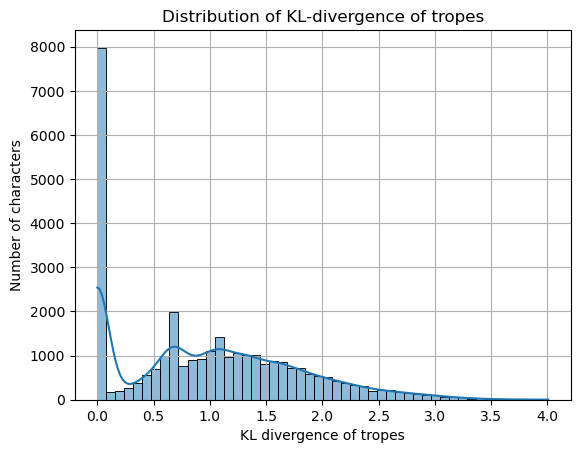

In [123]:
# Plot the tropes KL divergence distribution
sns.histplot(actors_characters_personas_genres["trope_kld"], bins=50, kde=True)
plt.xlabel("KL divergence of tropes")
plt.ylabel("Number of characters")
plt.title("Distribution of KL-divergence of tropes")
plt.grid()
plt.show()

As depicted in the above plot, our KL-divergence metric adheres to a smooth bell-shaped curve. Nevertheless, we note a distinct spike at $0$, which can be accounted for by the presence of actors consistently portraying the same tropes. Consequently, the empirical likelihood of them performing this trope is maximized (i.e., $0$), while the likelihood of them portraying any other tropes approaches $-\infty$.

In [124]:
# Merge the result back into the main dataframe
actors_characters_personas_genres = actors_characters_personas_genres.merge(actor_movies_with_genre[["freebase_map_id", "genres_freq"]],  on="freebase_map_id")

actors_characters_personas_genres["genre_kld"] = actors_characters_personas_genres.apply(
    lambda row: compute_kld_sum(row["actor_genres_freq"], row["genres_freq"]), axis=1
)

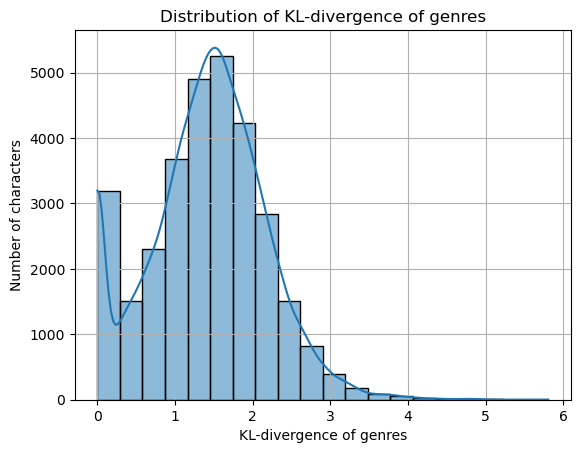

In [125]:
# Plot the genres KL divergence distribution
sns.histplot(actors_characters_personas_genres["genre_kld"], bins=20, kde=True)
plt.xlabel("KL-divergence of genres")
plt.ylabel("Number of characters")
plt.title("Distribution of KL-divergence of genres")
plt.grid(True)
plt.show()

We obtain a similar plot compared to the personas, but this time the spike at 0 is smaller than the one with the persona. This might mean that actors tend to play the same type of role (compared to their general type of role) **but** they seem to play in more diverse movie genres!

### Method 1: Ordinary Least Square

In gauging the performance of a movie, we will utilize the averageRating column from our dataset as a metric for assessing "how well a movie does." The box-office column, being notably sparse with a considerable amount of missing data, is not a practical solution. Although the average rating may not directly correlate with the financial aspect of "success," it generally serves as a reliable indicator of a movie's overall success.

In [126]:
df = actors_characters_personas_genres.merge(movies[["averageRating", "freebase_id"]], how="left")

In [127]:
# Method 1: OLS
X = df[["mip_trope", "trope_kld"]].to_numpy()
X = sm.add_constant(X)
Y = df["averageRating"].to_numpy()

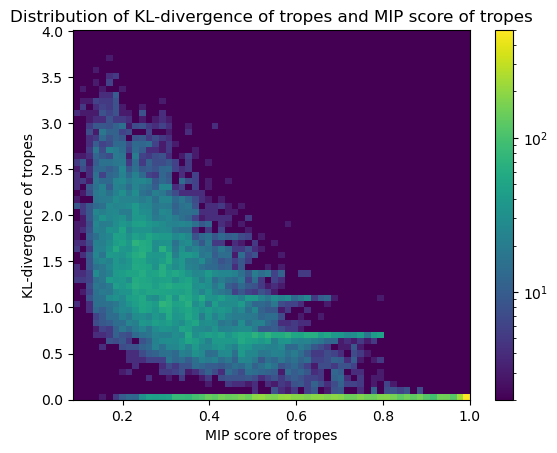

In [128]:
# Use pyplot.hist2d to plot the distribution of the mip_trope vs trope_kld
cmap = plt.cm.get_cmap('viridis')
cmap.set_bad(cmap(0))

plt.hist2d(X[:,1], X[:,2], bins=60, norm=mpl.colors.LogNorm(vmin=2, vmax=500), cmap=cmap)
plt.xlabel("MIP score of tropes")
plt.ylabel("KL-divergence of tropes")
plt.title("Distribution of KL-divergence of tropes and MIP score of tropes")
plt.colorbar()

In [129]:
# We use OLS to fit a linear regression model using the MIP score and the KL divergence of genres
sm.OLS(Y, X, missing='raise').fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     8.103
Date:                Thu, 21 Dec 2023   Prob (F-statistic):           0.000303
Time:                        23:12:15   Log-Likelihood:                -45212.
No. Observations:               31071   AIC:                         9.043e+04
Df Residuals:                   31068   BIC:                         9.046e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.3571      0.025    256.064      0.000       6.308       6.406
x1             0.1011      0.037      2.735      0.006       0.029       0.174
x2             0.0416      0.010      4.022      0.000       0.021       0.062
==============================================================================
Omnibus:                     2790.135   Durbin-Watson:                   1.393
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4112.607
Skew:                          -0.706   Prob(JB):                         0.00
Kurtosis:                       4.087   Cond. No.                         11.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Examining the F-statistic at $8.103$, with a corresponding p-value of $3.03e^{-3}$, it becomes evident that both mip_trope and trope_likelihood exert a statistically significant influence on averageRating. The low p-values associated with the coefficients of mip_trope (denoted as $x_1$) and trope_likelihood (denoted as $x_2$) under the null hypothesis that these variables are independent from `averageRating` further affirm this statistical significance. Notably, a higher `MIP` value, indicative of more specialized actors, appears to positively impact movie performance, as evidenced by the positive coefficient within the $95%$ confidence interval of $[0.029, 0.173]$. Conversely, engaging in familiar roles correlates positively with a movie's success, supported by the $95%$ confidence interval of $[0.021, 0.062]$.

However, it's crucial to recognize that this observed impact only explains a fraction of the variance, as reflected in the R-squared value of $0.001$. We could hypothesise that this minor influence is the result of some hidden baises and the correlation is due to confounding variables. If this hypothesis is verified then it would mean that `mip_trope` and `trope_likelihood` do not exert large influence on the `averageRating`.

In [130]:
# Same thing for genres
mask = ~np.isnan(df["genre_kld"]) & ~np.isnan(df["mip_genre"])
X = df[mask][["mip_genre", "genre_kld"]].to_numpy()
X = sm.add_constant(X)
Y = df[mask]["averageRating"].to_numpy()

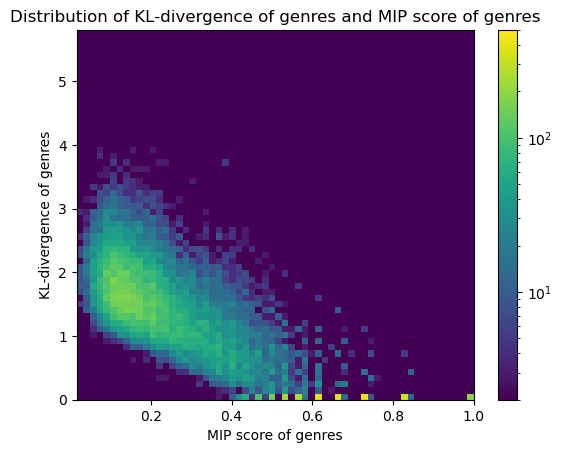

In [131]:
# Use pyplot.hist2d to plot the distribution of the mip_genre vs genre_kld
cmap = plt.cm.get_cmap('viridis')
cmap.set_bad(cmap(0))

plt.hist2d(X[:,1], X[:,2], bins=60, norm=mpl.colors.LogNorm(vmin=2, vmax=500), cmap=cmap)
plt.xlabel("MIP score of genres")
plt.ylabel("KL-divergence of genres")
plt.title("Distribution of KL-divergence of genres and MIP score of genres")
plt.colorbar()

In [132]:
# We use OLS to fit a linear regression model using the MIP score and the KL divergence of genres
sm.OLS(Y, X, missing='raise').fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     279.5
Date:                Thu, 21 Dec 2023   Prob (F-statistic):          5.05e-121
Time:                        23:12:15   Log-Likelihood:                -44899.
No. Observations:               31041   AIC:                         8.980e+04
Df Residuals:                   31038   BIC:                         8.983e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.0575      0.027    263.382      0.000       7.005       7.110
x1            -0.9772      0.047    -20.701      0.000      -1.070      -0.885
x2            -0.2518      0.011    -22.833      0.000      -0.273      -0.230
==============================================================================
Omnibus:                     2720.928   Durbin-Watson:                   1.388
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4039.077
Skew:                          -0.690   Prob(JB):                         0.00
Kurtosis:                       4.104   Cond. No.                         17.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The p-values under the null hypothesis that `averageRating` is independent from either `MIP` or `log-likelihood` are both $0.0$ respectively. As such both variable have significative statistical influence on the performance of a movie. The confidence interval at significance level of $95%$ for the impact of both parameters on the film performance are $[-1.070, -0.885]$ and $[-0.273, -0.230]$ respectively. This seems to indicate the the more an actor play in a genre he is used too, the less the movie is expected to perform. This conclusion is very unintuitive as we would expect the opposite to be true. The `F-statistic` of $279.5$, accompanied by a low p-value of basically $0$, seems to indicate that, collectively, the model is statistically significant.

The R-squared value is however still very low, it seems that both variables only contribute to explain $1\%$ of the overall variance. Therefore a more realistic conclusion would be to assume that this is due by a unobserved confounder variable. It would explain why this as such a small impact on the performance of a movie.

## (5) Are there roles that are acclaimed only when they are played by a specific group of actors ?

In [133]:
actors_characters_personas_ratings = pd.merge(
    actors_characters_personas,
    movies[['wiki_movie_id', 'averageRating']],
    on='wiki_movie_id').copy()

As a first approach we cluster characters based on their trope distribution to group them by similar personas. We group them into clusters where the characters share common traits. Then, within each cluster, we examine the influence of actors features (physical attributes) on the movies success measured in terms of average movie ratings.  
By analyzing each cluster separately, we aim to understand how certain actor features may affect movie ratings differently, depending on the nature of the personas in the movies. 

### The effect of gender

In [134]:
gender_cleaned=actors_characters_personas_ratings.dropna(subset=['actor_gender'])
print("Removed "+str(actors_characters_personas_ratings.size-gender_cleaned.size)+" rows where actor_gender is None")

Removed 9756 rows where actor_gender is None


#### Using Elbow Method to get the optimal number of clusters

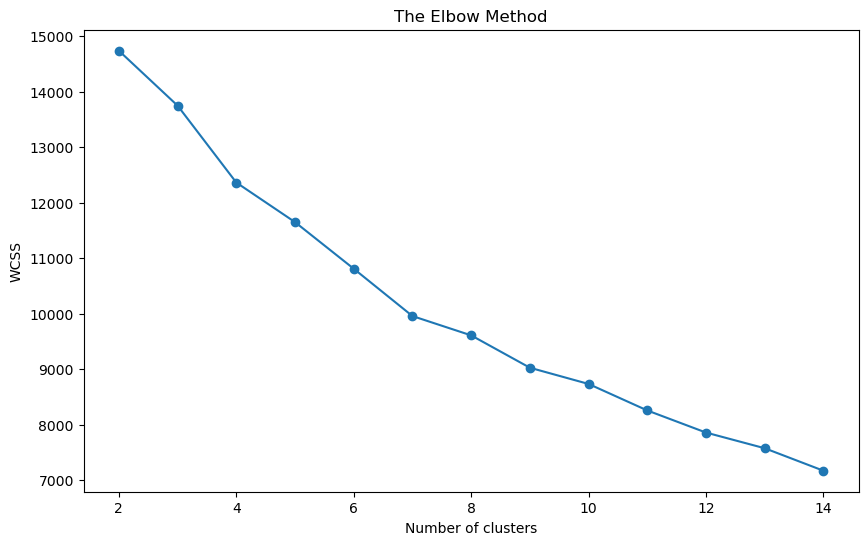

In [135]:
X = np.array(gender_cleaned['trope_distrib'].tolist())

wcss = []  # Within-cluster sum of squares
for i in range(2, 15):  # Testing for 2 to 15 clusters
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

# Plotting the results onto a line graph to observe 'The Elbow'
plt.figure(figsize=(10, 6))
plt.plot(range(2, 15), wcss, marker='o')
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

### Perform K-means++ and analyze results with OLS

In [136]:
kmeans = KMeans(n_clusters=7)  
kmeans.fit(X)

gender_cleaned['cluster'] = kmeans.labels_

for cluster in gender_cleaned['cluster'].unique():
    
    # Filter the DataFrame for the current cluster
    cluster_df  = gender_cleaned[gender_cleaned['cluster'] == cluster]
    cluster_df['M'] = (cluster_df['actor_gender'] == 'M').astype(int)


    X = cluster_df[['M']]# Independent variable 
    y = cluster_df['averageRating']  # Dependent variable

    # (intercept)
    X = sm.add_constant(X)

    # Performing the OLS regression
    model = sm.OLS(y, X).fit()

    # Print
    print(f'Cluster: {cluster}')
    print(model.summary())
    print("\n\n")

Cluster: 3
                            OLS Regression Results                            
Dep. Variable:          averageRating   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     11.36
Date:                Thu, 21 Dec 2023   Prob (F-statistic):           0.000763
Time:                        23:12:24   Log-Likelihood:                -3778.0
No. Observations:                2606   AIC:                             7560.
Df Residuals:                    2604   BIC:                             7572.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.2321      0.067     92.9

The influence of the gender on average movie ratings is neither consistent nor strong across various clusters. 
Although there are occasional statistically significant findings, the generally low R-squared values and minor coefficient sizes indicate that gender does not significantly impact the average ratings of movies.

### The effect of height

In [137]:
height_cleaned=actors_characters_personas_ratings.dropna(subset=['actor_height'])
print("Removed "+str(actors_characters_personas_ratings.size-height_cleaned.size)+" Row where actor_height is None")


Removed 149652 Row where actor_height is None


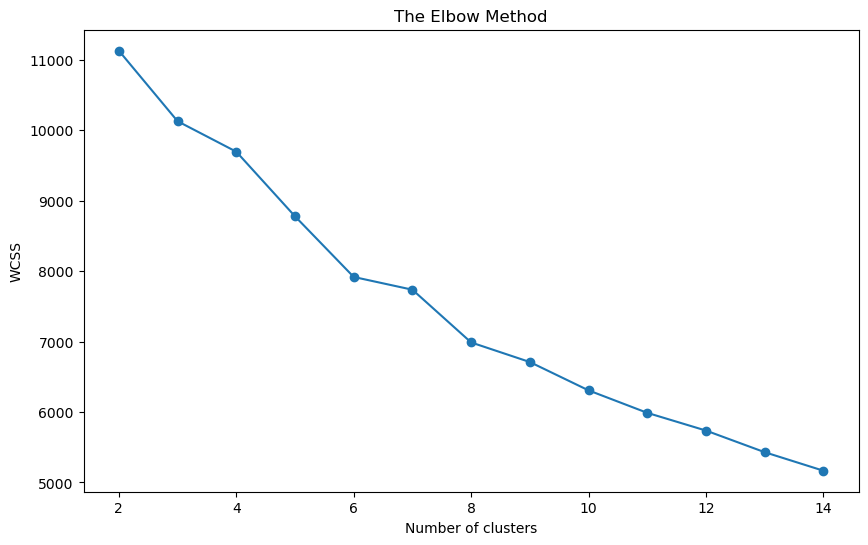

In [138]:
X = np.array(height_cleaned['trope_distrib'].tolist())
wcss = []  # Within-cluster sum of squares
for i in range(2, 15):  # Testing for 1 to 10 clusters
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

# Plotting the results onto a line graph to observe 'The Elbow'
plt.figure(figsize=(10, 6))
plt.plot(range(2, 15), wcss, marker='o')
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

### Perform K-means++ and analyze results with OLS

In [139]:
kmeans = KMeans(n_clusters=6)  
kmeans.fit(X)

height_cleaned['cluster'] = kmeans.labels_

for cluster in height_cleaned['cluster'].unique():
    # Filter the DataFrame for the current cluster
    cluster_df  = height_cleaned[height_cleaned['cluster'] == cluster]

    # Selecting the independent variable (X) and dependent variable (y)
    X = cluster_df[['actor_height']]  # Independent variable
    y = cluster_df['averageRating']  # Dependent variable

    # Adding a constant to the model (intercept)
    X = sm.add_constant(X)

    # Performing the OLS regression
    model = sm.OLS(y, X).fit()

    # Printing the summary of the regression for the current cluster
    print(f'Cluster: {cluster}')
    print(model.summary())
    print("\n\n")

Cluster: 3
                            OLS Regression Results                            
Dep. Variable:          averageRating   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.5017
Date:                Thu, 21 Dec 2023   Prob (F-statistic):              0.479
Time:                        23:12:29   Log-Likelihood:                -2851.8
No. Observations:                2000   AIC:                             5708.
Df Residuals:                    1998   BIC:                             5719.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            6.7642      0.479   

The OLS regression results give us The R-squared value is 0.000, indicating that actor height explains none of the variability in the average movie ratings.
The coefficient for actor_height is very close to 0 , which suggests that for each unit (1 meter) increase in actor height,
the success of the movie is basically not affected by it.
Therefore we may say that actor height has a very small and negligeable effect on the average rating of a movie.

## (6) Which features of an actor impact the distribution of his roles ?

In this section, we aim to explore whether an actor's ethnicity impacts the nature of their screen persona or the types of characters they portray in films. This analysis seeks to understand if ethnic background plays a significant role in shaping the roles and identities actors are associated with 

### Ethnicity Mapping

In [140]:
ethnicity_mapping = pd.read_json(os.path.join(SAVE_PATH, "ethnicity_map.json"))

In [141]:
ethnicity_mapping = dict(zip(ethnicity_mapping.eth_id, ethnicity_mapping.eth_name))

### Aggregate personas

In [142]:
def average_vectors(vectors):
    # Calculate the average of each element across all vectors
    avg_vector = [sum(x) / float(len(vectors)) for x in zip(*vectors)]
    return avg_vector

aggregated_data = actors_characters_personas.groupby('actor_name').agg({
    'trope_distrib': average_vectors,
    'actor_birth': 'first',   
    'actor_gender': 'first',  
    'actor_height': 'first',  
    'actor_ethnicity':'first' 
}).reset_index()

# Rename the aggregated column
aggregated_data.rename(columns={'trope_distrib': 'trope_distrib_aggregated'}, inplace=True)

# Select only the required columns
actor_tropes = aggregated_data[['actor_name', 'actor_gender','actor_ethnicity','actor_birth', 'actor_height', 'trope_distrib_aggregated']]
actor_tropes

,actor_name,actor_gender,actor_ethnicity,actor_birth,actor_height,trope_distrib_aggregated
0,50 Cent,M,/m/0x67,1975-07-06,1.829,"[0.0, 0.0049999999000000005, 0.0, 0.0, 0.0, 0...."
1,A. J. Bowen,M,None,1977-12-21,NaN,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,A. J. Cook,F,None,1978-07-22,1.690,"[0.0, 0.15666666626666667, 0.0, 0.0, 0.0, 0.00..."
3,A. J. Langer,F,None,1974-05-22,1.550,"[0.0, 0.050000000700000005, 0.0, 0.0, 0.0, 0.0..."
4,A.D. Miles,M,None,1971-11-08,NaN,"[0.0, 0.0, 0.1400000006, 0.0, 0.0, 0.0, 0.0, 0..."
...,...,...,...,...,...,...
11920,Íñigo Garcés,M,None,1987-12-31,NaN,"[0.0, 0.1700000018, 0.0, 0.0, 0.0, 0.0, 0.0, 0..."
11921,Þröstur Leó Gunnarsson,M,None,1961-04-23,NaN,"[0.0, 0.0, 0.6299999952, 0.0, 0.0, 0.0, 0.0, 0..."
11922,İsmail Hacıoğlu,M,None,1985-11-30,NaN,"[0.0, 0.0, 0.200000003, 0.3600000143, 0.0, 0.0..."
11923,Željko Ivanek,M,/m/04_tz7,1957-08-15,1.700,"[0.0, 0.0, 0.15000000600000002, 0.0, 0.0, 0.0,..."


In [143]:
actor_tropes['actor_ethnicity'] = actor_tropes['actor_ethnicity'].map(ethnicity_mapping)
ethnicity_cleaned=actor_tropes.dropna(subset=['actor_ethnicity'])

# Initialize the list that will contain all the vectors
ethnicity_persona_vector = []

# Create the vectors for each element of the trope distribution
for i in range(50):
    ethnicity_trope_vector = [
        (ethnicity, trope_distrib[i])
        for ethnicity, trope_distrib in zip(ethnicity_cleaned['actor_ethnicity'], ethnicity_cleaned['trope_distrib_aggregated'])
    ]
    ethnicity_persona_vector.append(ethnicity_trope_vector)
ethnicity_cleaned

,actor_name,actor_gender,actor_ethnicity,actor_birth,actor_height,trope_distrib_aggregated
0,50 Cent,M,African American,1975-07-06,1.829,"[0.0, 0.0049999999000000005, 0.0, 0.0, 0.0, 0...."
7,A.K Hangal,M,Kashmiri Pandit,1917-02-01,NaN,"[0.0, 0.0, 0.1400000006, 0.0700000003, 0.0, 0...."
8,Aaliyah,F,African American,1979-01-16,1.650,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
10,Aamir Ali,M,Indian people,1979-09-01,1.800,"[0.0, 0.0, 0.7599999905, 0.0, 0.0, 0.0, 0.0, 0..."
11,Aamir Khan,M,Afghans in India,1965-03-14,1.680,"[0.0, 0.0, 0.18499999987, 0.200000000385, 0.0,..."
...,...,...,...,...,...,...
11910,Zoë Kravitz,F,African American,1988-12-01,1.570,"[0.0, 0.0049999999000000005, 0.114999998350000..."
11911,Zsa Zsa Gábor,F,Hungarian American,1917-02-06,1.630,"[0.0, 0.0, 0.05999999912500001, 0.022499999500..."
11918,Élodie Bouchez,F,White people,1973-04-05,NaN,"[0.0, 0.0, 0.2700000107, 0.0399999991, 0.0, 0...."
11919,Émilie Dequenne,F,Belgian people,1981-08-29,NaN,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.009999999800000001..."


In [144]:
persona_df = pd.DataFrame(ethnicity_persona_vector[1], columns=['Ethnicity', 'PersonaValue']).copy()
persona_df

,Ethnicity,PersonaValue
0,African American,0.005
1,Kashmiri Pandit,0.000
2,African American,0.000
3,Indian people,0.000
4,Afghans in India,0.000
...,...,...
3144,African American,0.005
3145,Hungarian American,0.000
3146,White people,0.000
3147,Belgian people,0.000


### Inspect results

### Testing for Persona(4)

In [277]:
persona_df = pd.DataFrame(ethnicity_persona_vector[3], columns=['Ethnicity', 'PersonaValue'])
# Apply one-hot encoding to the 'Ethnicity' column
ethnicity_dummies = pd.get_dummies(persona_df['Ethnicity'])

# Prepare the data for OLS
X = ethnicity_dummies  # Independent variables
Y = persona_df['PersonaValue']  # Dependent variable

# Add a constant to the independent variables
X = sm.add_constant(X)

# Fit the OLS model
model = sm.OLS(Y, X).fit()

# Print out the summary statistics
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           PersonaValue   R-squared:                       0.324
Model:                            OLS   Adj. R-squared:                  0.251
Method:                 Least Squares   F-statistic:                     4.443
Date:                Fri, 22 Dec 2023   Prob (F-statistic):          7.45e-101
Time:                        01:06:11   Log-Likelihood:                 2517.1
No. Observations:                3149   AIC:                            -4420.
Df Residuals:                    2842   BIC:                            -2561.
Df Model:                         306                                         
Covariance Type:            nonrobust                                         
                                                     coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------

In [278]:
top_words = list(frequent_terms[str(4)].values())
top_words = list(map(list, zip(*top_words)))

print("Top words for Persona 4")
print(tabulate(top_words, headers=frequent_terms[str(34)].keys(), tablefmt="fancy_grid"))

Top words for Persona 4
╒═════════╤═══════════╤════════════╕
│ agent   │ patient   │ modifiee   │
╞═════════╪═══════════╪════════════╡
│ arrive  │ go        │ close      │
├─────────┼───────────┼────────────┤
│ meet    │ turn      │ elder      │
├─────────┼───────────┼────────────┤
│ accept  │ put       │ orphan     │
├─────────┼───────────┼────────────┤
│ believe │ throw     │ mom        │
├─────────┼───────────┼────────────┤
│ think   │ reveal    │ other      │
├─────────┼───────────┼────────────┤
│ escape  │ bring     │ lover      │
├─────────┼───────────┼────────────┤
│ accept  │ unite     │ dead       │
├─────────┼───────────┼────────────┤
│ like    │ make      │ former     │
├─────────┼───────────┼────────────┤
│ stay    │ like      │ angry      │
├─────────┼───────────┼────────────┤
│ help    │ impress   │ new        │
╘═════════╧═══════════╧════════════╛


**Persona 4**
<!-- ["lose", "stop", "help", "wait", "confront", "explain", "make", "go", "love", "find", "take", 
"talk", "get", "show", "see", "call", "meet", "give", "ask", "tell"]
 -->
| Ethnicity        | Coefficient | p-value |
|------------------|-------------|---------|
| Hindu            | 0.4510      | 0.000   |
| Dogra            | 0.6210      | 0.000   |
| Mangaloreans     | 0.3921      | 0.001   |
| Hindkowans       | 0.3548      | 0.002   |
| Finns            | 0.3644      | 0.000   |
| Bengali Hindus   | 0.2307      | 0.000   |
| Gujarati people  | 0.2265      | 0.000   |

### Testing for Persona(42)

In [219]:
persona_df = pd.DataFrame(ethnicity_persona_vector[41], columns=['Ethnicity', 'PersonaValue'])
# Apply one-hot encoding to the 'Ethnicity' column
ethnicity_dummies = pd.get_dummies(persona_df['Ethnicity'])

# Prepare the data for OLS
X = ethnicity_dummies  # Independent variables
Y = persona_df['PersonaValue']  # Dependent variable

# Add a constant to the independent variables
X = sm.add_constant(X)

# Fit the OLS model
model = sm.OLS(Y, X).fit()

# Print out the summary statistics
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           PersonaValue   R-squared:                       0.162
Model:                            OLS   Adj. R-squared:                  0.072
Method:                 Least Squares   F-statistic:                     1.799
Date:                Fri, 22 Dec 2023   Prob (F-statistic):           3.54e-14
Time:                        00:13:41   Log-Likelihood:                 2695.0
No. Observations:                3149   AIC:                            -4776.
Df Residuals:                    2842   BIC:                            -2917.
Df Model:                         306                                         
Covariance Type:            nonrobust                                         
                                                     coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------

In [218]:
top_words = list(frequent_terms[str(42)].values())
top_words = list(map(list, zip(*top_words)))

print("Top words for Persona 42")
print(tabulate(top_words, headers=frequent_terms[str(34)].keys(), tablefmt="fancy_grid"))

Top words for Persona 42
╒═════════╤═══════════╤════════════╕
│ agent   │ patient   │ modifiee   │
╞═════════╪═══════════╪════════════╡
│ stop    │ go        │ worker     │
├─────────┼───────────┼────────────┤
│ murder  │ turn      │ terrorist  │
├─────────┼───────────┼────────────┤
│ suspect │ put       │ able       │
├─────────┼───────────┼────────────┤
│ stab    │ throw     │ black      │
├─────────┼───────────┼────────────┤
│ hit     │ reveal    │ partner    │
├─────────┼───────────┼────────────┤
│ flee    │ stop      │ lover      │
├─────────┼───────────┼────────────┤
│ plan    │ murder    │ dead       │
├─────────┼───────────┼────────────┤
│ reveal  │ suspect   │ former     │
├─────────┼───────────┼────────────┤
│ get     │ stab      │ angry      │
├─────────┼───────────┼────────────┤
│ hide    │ hit       │ new        │
╘═════════╧═══════════╧════════════╛


**Persona 42**:

| Ethnicity          | Coefficient | p-value |
|--------------------|-------------|---------|
| Tamil American     | 0.7882      | <0.001  |
| Belgians           | 0.7782      | <0.001  |
| Moroccans          | 0.5482      | <0.001  |
| Sephardi Jews      | 0.4249      | <0.001  |
| Afro-Asian         | 0.3932      | <0.001  |
| Portuguese people  | 0.3882      | <0.001  |
| Finnish American   | 0.2482      | 0.022   |

### Testing for Persona(49)

In [222]:
persona_df = pd.DataFrame(ethnicity_persona_vector[48], columns=['Ethnicity', 'PersonaValue'])
# Apply one-hot encoding to the 'Ethnicity' column
ethnicity_dummies = pd.get_dummies(persona_df['Ethnicity'])

# Prepare the data for OLS
X = ethnicity_dummies  # Independent variables
Y = persona_df['PersonaValue']  # Dependent variable

# Add a constant to the independent variables
X = sm.add_constant(X)

# Fit the OLS model
model = sm.OLS(Y, X).fit()

# Print out the summary statistics
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           PersonaValue   R-squared:                       0.156
Model:                            OLS   Adj. R-squared:                  0.066
Method:                 Least Squares   F-statistic:                     1.721
Date:                Fri, 22 Dec 2023   Prob (F-statistic):           2.84e-12
Time:                        00:21:21   Log-Likelihood:                 5862.6
No. Observations:                3149   AIC:                        -1.111e+04
Df Residuals:                    2842   BIC:                            -9252.
Df Model:                         306                                         
Covariance Type:            nonrobust                                         
                                                     coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------

In [223]:
top_words = list(frequent_terms[str(49)].values())
top_words = list(map(list, zip(*top_words)))

print("Top words for Persona 49")
print(tabulate(top_words, headers=frequent_terms[str(27)].keys(), tablefmt="fancy_grid"))

Top words for Persona 49
╒══════════╤═══════════╤════════════╕
│ agent    │ patient   │ modifiee   │
╞══════════╪═══════════╪════════════╡
│ impale   │ go        │ lover      │
├──────────┼───────────┼────────────┤
│ force    │ turn      │ dead       │
├──────────┼───────────┼────────────┤
│ strangle │ put       │ former     │
├──────────┼───────────┼────────────┤
│ throw    │ throw     │ angry      │
├──────────┼───────────┼────────────┤
│ appear   │ reveal    │ new        │
├──────────┼───────────┼────────────┤
│ ambush   │ learn     │ other      │
├──────────┼───────────┼────────────┤
│ pursue   │ finish    │ dog        │
├──────────┼───────────┼────────────┤
│ continue │ restore   │ first      │
├──────────┼───────────┼────────────┤
│ try      │ summon    │ ghost      │
├──────────┼───────────┼────────────┤
│ fall     │ join      │ evil       │
╘══════════╧═══════════╧════════════╛


**Persona 49**:  

| Ethnicity           | Coefficient | p-value |
|---------------------|-------------|---------|
| Albanian American   | 0.1924      | <0.001  |
| Irish Canadian      | 0.1214      | 0.000   |
| Hong Kong people    | 0.0271      | 0.024   |
| Dominican American  | 0.0639      | 0.022   |
| Norwegian American  | 0.0356      | 0.028   |
| Serbian Australian  | 0.6923      | <0.001  |
| Ryukyuan people     | 0.0523      | 0.062   

### Testing for Persona(50)

In [227]:
persona_df = pd.DataFrame(ethnicity_persona_vector[49], columns=['Ethnicity', 'PersonaValue'])
# Apply one-hot encoding to the 'Ethnicity' column
ethnicity_dummies = pd.get_dummies(persona_df['Ethnicity'])

# Prepare the data for OLS
X = ethnicity_dummies  # Independent variables
Y = persona_df['PersonaValue']  # Dependent variable

# Add a constant to the independent variables
X = sm.add_constant(X)

# Fit the OLS model
model = sm.OLS(Y, X).fit()

# Print out the summary statistics
print(model.summary()) 

                            OLS Regression Results                            
Dep. Variable:           PersonaValue   R-squared:                       0.106
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     1.096
Date:                Fri, 22 Dec 2023   Prob (F-statistic):              0.132
Time:                        00:26:51   Log-Likelihood:                 1266.1
No. Observations:                3149   AIC:                            -1918.
Df Residuals:                    2842   BIC:                            -59.29
Df Model:                         306                                         
Covariance Type:            nonrobust                                         
                                                     coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------

In [228]:
top_words = list(frequent_terms[str(50)].values())
top_words = list(map(list, zip(*top_words)))

print("Top words for Persona 50")
print(tabulate(top_words, headers=frequent_terms[str(49)].keys(), tablefmt="fancy_grid"))

Top words for Persona 50
╒═════════╤═══════════╤════════════╕
│ agent   │ patient   │ modifiee   │
╞═════════╪═══════════╪════════════╡
│ put     │ reject    │ close      │
├─────────┼───────────┼────────────┤
│ read    │ apologize │ elder      │
├─────────┼───────────┼────────────┤
│ drive   │ know      │ orphan     │
├─────────┼───────────┼────────────┤
│ stay    │ spend     │ mom        │
├─────────┼───────────┼────────────┤
│ feel    │ come      │ other      │
├─────────┼───────────┼────────────┤
│ arrive  │ lose      │ lover      │
├─────────┼───────────┼────────────┤
│ meet    │ stop      │ dead       │
├─────────┼───────────┼────────────┤
│ accept  │ help      │ former     │
├─────────┼───────────┼────────────┤
│ believe │ wait      │ angry      │
├─────────┼───────────┼────────────┤
│ think   │ confront  │ new        │
╘═════════╧═══════════╧════════════╛


**Persona 50**:  

| Ethnicity                       | Coefficient | p-value |
|---------------------------------|-------------|---------|
| Ecuadorian American             | 0.8601      | 0.000   |
| Sikh                            | 0.7051      | 0.000   |
| Thai Chinese                    | 0.5051      | 0.003   |
| Swedish Canadian                | 0.4561      | 0.007   |
| Greek Canadians                 | 0.3976      | 0.001   |
| Afro-Cuban                      | 0.3601      | 0.034   |
| Chitrapur Saraswat Brahmin      | 0.3034      | 0.012   |
| Garhwali people                 | 0.4101      | 0.016   |
| Italian Brazilian               | 0.2601      | 0.031   |